In [1]:
import os
import sys
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import neptune
from neptune.utils import stringify_unsupported
from ruamel.yaml import YAML
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from torchvision.transforms import RandomRotation, RandomCrop
from torchvision.transforms.functional import InterpolationMode
from tqdm import tqdm
import torch.nn.functional as F


from multiplex_model.data import DatasetFromTIFF, PanelBatchSampler, TestCrop
from multiplex_model.losses import nll_loss
from multiplex_model.utils import ClampWithGrad, plot_reconstructs_with_uncertainty, get_scheduler_with_warmup
from multiplex_model.modules import MultiplexAutoencoder
from multiplex_model.run_utils import build_run_name_suffix, SLURM_JOB_ID


In [58]:
import pandas as pd
df = pd.read_pickle("/raid/immucan/immuw/data/NSCLC_vq_embeds.pkl")

In [59]:
df.head()

,img_path,panel,coords0,coords1,embeddings,split
0,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 0)","(112, 112)","[[38, 51, 34, 105, 34, 219, 34, 34, 32, 128, 2...",train
1,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 112)","(112, 224)","[[233, 89, 153, 153, 219, 219, 153, 125, 34, 3...",train
2,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 224)","(112, 336)","[[120, 156, 176, 148, 9, 203, 135, 126, 176, 2...",train
3,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 336)","(112, 448)","[[135, 124, 59, 129, 144, 124, 152, 203, 229, ...",train
4,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 448)","(112, 560)","[[134, 134, 134, 134, 134, 83, 134, 134, 134, ...",train


In [60]:
df.dtypes

img_path      object
panel          int64
coords0       object
coords1       object
embeddings    object
split         object
dtype: object

In [61]:
type(df["embeddings"].iloc[0])

numpy.ndarray

In [62]:
import os
import sys
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import neptune
from neptune.utils import stringify_unsupported
from ruamel.yaml import YAML
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from torchvision.transforms import RandomRotation, RandomCrop
from tqdm import tqdm
from torchvision import transforms

# ModuleNotFoundError: No module named 'multiplex_model'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from multiplex_model.data import DatasetFromTIFF, PanelBatchSampler, TestCrop
from multiplex_model.losses import nll_loss
from multiplex_model.utils import ClampWithGrad, plot_reconstructs_with_uncertainty, get_scheduler_with_warmup
from multiplex_model.modules import MultiplexAutoencoder
from multiplex_model.run_utils import build_run_name_suffix, SLURM_JOB_ID


from src_from_rudy.utils import setup_seeds, setup_clearml, ChainDataLoader
from src_from_rudy.augmentations import ArcsinhNormalize, MinMaxNormalize, ButterworthFilter, GlobalNormalize, SelectMarkers
from src_from_rudy.config.autoencoder_cells import Config as CellsConfig
from src_from_rudy.config.multiplex_vit_no_bottleneck_autoencoder import Config as TissuesConfig
from src_from_rudy.constants import LOGDIR, IMC_PANEL2_DATA_DIR, PANEL_1_MARKER_NAMES, IMC_PANEL1_DATA_DIR, HALEY_GLIO, DANENBERG_BREAST_DIR, REQUIRED_IMG_SHAPES
from src_from_rudy.datasets.imc_datasets import CellPatchesDataModule, WholeSlidesDataModule, ContrastiveTissuePatchesDataModule, TissuePatchesDataModule



CONFIG_OVERRIDES = {
    "device": "cpu",  # Change to 'cuda:0' if using GPU
    "panel_config": "configs/all_panels_config.yaml",
    "tokenizer_config": "configs/all_markers_tokenizer.yaml"
}

global TOKENIZER, INV_TOKENIZER, PANEL_CONFIG

def apply_overrides(config, overrides):
    for key, value in overrides.items():
        if key in config:
            config[key] = value
        else:
            print(f"Warning: {key} not found in config, skipping override.")
    return config

def load_configuration(config_path):
    yaml = YAML(typ='safe')
    with open(config_path, 'r') as f:
        config = yaml.load(f)
    
    with open("secrets/neptune.yaml", 'r') as f:
        secrets = yaml.load(f)
    config = apply_overrides(config, CONFIG_OVERRIDES)

    prefix = config.get("run_prefix", "").strip()         # empty by default
    suffix = build_run_name_suffix()                               # always unique
    run_name = f"{prefix}_{suffix}" if prefix else suffix

    run = neptune.init_run(
        name=run_name,
        project=secrets['neptune_project'],
        api_token=secrets['neptune_api_token'],
        tags=config['tags'],
    )

    device = config['device']
    print(f'Using device: {device}')

    SIZE = config['input_image_size']
    print(f"INPUT IMAGE SIZE: {SIZE}")
    BATCH_SIZE = config['batch_size']
    NUM_WORKERS = config['num_workers']

    PANEL_CONFIG = YAML().load(open(config['panel_config']))
    # PANEL_CONFIG["datasets"] = ["nsclc2-panel1"]
    TOKENIZER = YAML().load(open(config['tokenizer_config']))
    print(f"Training on datasets: {PANEL_CONFIG['datasets']}")
    MARKERS_SET = {k for dataset in PANEL_CONFIG['datasets'] for k in PANEL_CONFIG['markers'][dataset]}
    print(f"Markers set: {MARKERS_SET}")
    print(f"Number of markers: {len(MARKERS_SET)}")
    TOKENIZER = {k: v for k, v in zip(MARKERS_SET, range(len(MARKERS_SET)))}
    INV_TOKENIZER = {v: k for k, v in TOKENIZER.items()}

    train_transform = Compose([
        # RandomRotation(180),
        TestCrop(SIZE[0]),
    ])

    test_transform = TestCrop(SIZE[0])

    train_dataset = DatasetFromTIFF(
        panels_config=PANEL_CONFIG,
        split='train',
        marker_tokenizer=TOKENIZER,
        transform=train_transform,
        use_median_denoising=False,
        use_butterworth_filter=True
    )

    test_dataset = DatasetFromTIFF(
        panels_config=PANEL_CONFIG,
        split='test',
        marker_tokenizer=TOKENIZER,
        transform=test_transform,
        use_median_denoising=False,
        use_butterworth_filter=True
    )

    train_batch_sampler = PanelBatchSampler(train_dataset, BATCH_SIZE)
    test_batch_sampler = PanelBatchSampler(test_dataset, BATCH_SIZE, shuffle=False)

    train_dataloader = DataLoader(train_dataset, batch_sampler=train_batch_sampler, num_workers=NUM_WORKERS)
    test_dataloader = DataLoader(test_dataset, batch_sampler=test_batch_sampler, num_workers=NUM_WORKERS)

    model_config = {
        'num_channels': len(TOKENIZER),
        'superkernel_config': config['superkernel'],
        'encoder_config': config['encoder'],
        'decoder_config': config['decoder'],
    }

    if config["model_type"] == "EquivariantConvnext":
        from multiplex_model.equivariant_modules import EquivariantMultiplexAutoencoder
        model = EquivariantMultiplexAutoencoder(**model_config).to(device)
    elif config["model_type"] == "Convnext":
        model = MultiplexAutoencoder(**model_config).to(device)

    print(f'Model created with config: {model_config}')
    print(f'Model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters')
    print(f'Model: {model}')
    print(f'Training on {len(train_dataloader.dataset)} training samples and {len(test_dataloader.dataset)} test samples')
    print(f'Batch size: {BATCH_SIZE}, Number of workers: {NUM_WORKERS}')
    return model, train_dataloader, test_dataloader, TOKENIZER, INV_TOKENIZER, config

config_path = "/raid/szlukasik/immu-vis/multiplex-image-model/train_masked_equivariant_config_impainting.yaml"
model, train_dataloader, test_dataloader, TOKENIZER, INV_TOKENIZER, config = load_configuration(config_path)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/immu-vis/patch-autoencoders/e/IM-390
Using device: cpu
INPUT IMAGE SIZE: [113, 113]
Training on datasets: ['ajaib', 'bc2', 'bengsch', 'bowen-lynch', 'cho_2025', 'cords', 'cords-fibro', 'damond-lung', 'danenberg', 'ehret_2025_p1', 'ehret_2025_p2', 'einhaus_2025', 'haley_glio', 'hn', 'hoch-protein', 'hoch-rna', 'jackson-basel', 'jackson-zurich', 'kucukkose', 'nsclc2-panel1', 'nsclc2-panel2', 'ohara', 'steenbuck-immune', 'steenbuck-islets', 'susman', 'xu']
Markers set: {'PM3', 'IL17a', 'XBP1', 'CD103', 'CD206', 'TMEM119', 'PM2', 'PDGFRb', 'FAP', 'GPA33', 'ANXA1', 'GHRL', 'CXCL8', 'Met', 'FOXP3', 'Podoplanin', 'GATA3', 'CXCL10', 'CD79A', 'P2RY12', 'NeuN', 'PD1', 'LDHA', 'PPY', 'Biotin', 'AMY1A', 'CD31-vWF', 'SYP', 'HLADR', 'Arg1', 'CCL8', 'CD204', 'CTLA-4', 'JARID2-C', 'SMA', 'ER', 'CHGA', 'TOX', 'pSTAT3', 'VCAM1', 'panCK', 'PDX1', 'BCAN', 'CD40', 'CK7', 'EOMES', 'TNC', 'pMAPKAPK2', 'CD209', 'AMY2A', 'Insulin'

KeyboardInterrupt: 

In [ ]:
model

NameError: name 'model' is not defined

In [ ]:
import torch
# load model ckpt
# ckpt_path = "checkpoints/checkpoint-IM-41-epoch_149.pth"
# ckpt_path = "/raid/szlukasik/immu-vis/multiplex-image-model/checkpoints/checkpoint-EquivariantConvnext_20250827_002044_J1611-epoch_999.pth"
ckpt_path = "/raid/szlukasik/immu-vis/multiplex-image-model/checkpoints/checkpoint-EquivariantConvnext_20251004_191704_J2206-epoch_179.pth"
# ckpt_path = "/raid/szlukasik/immu-vis/multiplex-image-model/checkpoints/checkpoint-EquivariantConvnext_20250821_022303_J1444-epoch_79.pth"


state_dict = torch.load(ckpt_path, map_location='cpu')

/tmp/ipykernel_1456470/3769188788.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location='cpu')


In [ ]:

config_path = "/raid/szlukasik/immu-vis/multiplex-image-model/configs/train_masked_config_base.yaml"
yaml = YAML(typ='safe')
with open(config_path, 'r') as f:
    config = yaml.load(f)


In [ ]:
config['from_checkpoint'] = "models/model-UN-232-ds_depend_clip.pth"

In [ ]:
PANEL_CONFIG = YAML().load(open(config['panel_config']))
TOKENIZER = YAML().load(open(config['tokenizer_config']))
model_config = {
        'num_channels': len(TOKENIZER),
        'superkernel_config': config['superkernel'],
        'encoder_config': config['encoder'],
        'decoder_config': config['decoder'],
    }
model = MultiplexAutoencoder(**model_config)

In [ ]:
from ruamel.yaml import YAML
PANEL_CONFIG = YAML().load(open(config['panel_config']))
PANEL_CONFIG["datasets"] = ["nsclc2-panel1"]
# TOKENIZER = YAML().load(open(config['tokenizer_config']))
# model_config = {
#         'num_channels': len(TOKENIZER),
#         'superkernel_config': config['superkernel'],
#         'encoder_config': config['encoder'],
#         'decoder_config': config['decoder'],
#     }
# model = MultiplexAutoencoder(**model_config)

In [ ]:
device = "cuda:0"

In [ ]:
state_dict['model_state_dict'].keys()

odict_keys(['superkernel.embedder.weight', 'encoder.poolings.0.bias', 'encoder.poolings.0.weights', 'encoder.poolings.0.bias_expansion', 'encoder.poolings.0.filter', 'encoder.poolings.0.expanded_bias', "encoder.poolings.0._basisexpansion.block_expansion_('irrep_0', 'regular_1').sampled_basis", 'encoder.poolings.1.bias', 'encoder.poolings.1.weights', 'encoder.poolings.1.bias_expansion', 'encoder.poolings.1.filter', 'encoder.poolings.1.expanded_bias', "encoder.poolings.1._basisexpansion.block_expansion_('regular_1', 'regular_1').sampled_basis", 'encoder.poolings.2.bias', 'encoder.poolings.2.weights', 'encoder.poolings.2.bias_expansion', 'encoder.poolings.2.filter', 'encoder.poolings.2.expanded_bias', "encoder.poolings.2._basisexpansion.block_expansion_('regular_1', 'regular_1').sampled_basis", 'encoder.acts.0.log_bias', 'encoder.acts.0.eps', 'encoder.acts.0.indices_3', 'encoder.acts.1.log_bias', 'encoder.acts.1.eps', 'encoder.acts.1.indices_3', 'encoder.acts.2.log_bias', 'encoder.acts.2.

In [ ]:
# checkpoint = torch.load(config['from_checkpoint'], map_location=device)
model.load_state_dict(state_dict['model_state_dict'])   
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [ ]:
train_dataset = DatasetFromTIFF(
    panels_config=PANEL_CONFIG,
    split='train',
    marker_tokenizer=TOKENIZER,
    transform=Compose([]),
    use_median_denoising=False,
    use_butterworth_filter=True,
    use_minmax_normalization=False,
    use_clip_normalization=True
)

In [ ]:
test_dataset = DatasetFromTIFF(
    panels_config=PANEL_CONFIG,
    split='test',
    marker_tokenizer=TOKENIZER,
    transform=Compose([
        # TestCrop(113)
        ]),
    use_median_denoising=False,
    use_butterworth_filter=True,
    use_minmax_normalization=False,
    use_clip_normalization=True
)

In [ ]:
subset = torch.utils.data.Subset(train_dataset, list(range(len(train_dataset)//4)))

In [ ]:
train_dataloader = DataLoader(subset)


In [ ]:

test_dataloader = DataLoader(test_dataset)

In [ ]:
train_dataloader = DataLoader(train_dataset)
test_dataloader = DataLoader(test_dataset)

In [ ]:
subset = torch.utils.data.Subset(train_dataset, list(range(len(train_dataset)//4)))

In [ ]:
train_dataloader = DataLoader(subset)


In [ ]:
panel_1_markers = PANEL_CONFIG['markers']['nsclc2-panel1']
panel_1_indices = [TOKENIZER.get(marker) for marker in panel_1_markers]
panel_1_markers

['B2M', 'Carbonic Anhydrase', 'CD11c', 'CD14', 'CD15', 'CD16', 'CD163', 'CD20', 'CD206', 'CD27', 'CD3', 'CD303', 'CD33', 'CD38', 'CD4', 'CD40', 'CD45RA', 'CD45RO', 'CD68', 'CD7', 'CD8a', 'cl.PARP', 'DNA1', 'DNA2', 'Ecad', 'FOXP3', 'GrzB', 'Histone H3', 'HLADR', 'ICOS', 'Ido1', 'Ki67', 'LAG3', 'MPO', 'PD1', 'PDGFRb', 'PDL1', 'SMA', 'TCF7', 'VISTA']

In [ ]:
model = model.to(device)

In [ ]:
model = model.eval()

In [ ]:
# images are of shape (B, C, H, W) where H, W = 600 We want to process a grid of distinct patches of size 112x112
for idx, (img, channel_ids, panel_idx, img_path) in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
results_images = {}
    # assert that shape is 600x600
    # assert img.shape[-2:] == (600, 600), f"Image shape is {img.shape[-2:]}, expected (600, 600)"
    if img.shape[-2:] != (600, 600):
        print(f"Skipping image {img_path} with shape {img.shape[-2:]}, expected (600, 600)")
        continue
    img = img.to(device).to(torch.float32)
    # print(img.shape)
    # I want to process the image in a following way - [0:112, 0:112], [0:112, 112:224], ... [0:112, 488:600]
    patches_indices = [
        [(slice(i, i + 113), slice(j, j + 113)) for j in range(0, 565, 113)] + [(slice(i, i + 113), slice(487, 600))]
        for i in range(0, 565, 113)
    ] + [[(slice(487, 600), slice(j, j + 113)) for j in range(0, 565, 113)] + [(slice(487, 600), slice(487, 600))]]
    patches_indices_flat = [item for sublist in patches_indices for item in sublist]
    # assert that for all patches the shape is (B, C, 112, 112)
    # for h_idx, w_idx in patches_indices_flat:
    #     patch = img[:, :, h_idx, w_idx]
    #     assert patch.shape[-2:] == (112, 112), f"Patch shape is {patch.shape[-2:]}, expected (112, 112)"
    # print(patches_indices_flat[-1])
    # break
    results_patches = []
    for patch_idx, (h_idx, w_idx) in enumerate(patches_indices_flat):
        results_rotatations = {}
        for rotation, flip in ((0, 1), (90, 1), (180, 1), (270, 1)):
            for flip in range(flip + 1):
                patch = img[:, :, h_idx, w_idx]
                # print(patch.shape)
                if rotation > 0:
                    patch = torch.rot90(patch, k=rotation // 90, dims=[-2, -1])
                if flip > 0:
                    patch = torch.flip(patch, dims=[-1])
                
                encoded_indices = torch.tensor([panel_1_indices]).to(device)
                with torch.no_grad():
                    outputs = model(patch, encoded_indices,  encoded_indices, True)
                embedding = outputs["features"][-1]
                embedding_rotated = embedding.clone()
                if flip > 0:
                    embedding = torch.flip(embedding, dims=[-1])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(- rotation // 90), dims=[-2, -1])
                mi, logsigma = outputs["output"][:, :, 3:-4, 3:-4, :].unbind(dim=-1)
                # print(mi.shape, logsigma.shape, patch.shape)
                # print(mi.shape, logsigma.shape, patch.shape)
                mi = torch.sigmoid(mi)
                loss = nll_loss(patch, mi, logsigma)
                mae = torch.abs(patch - mi).mean()

                mae_between_embeddings = torch.tensor(0.0)
                if rotation > 0 or (flip > 0):
                    org_embedding = torch.tensor(results_rotatations["r0_nf"]['embedding']).to(device)
                    mae_between_embeddings = ((embedding -  org_embedding) ** 2).mean() / (org_embedding ** 2).mean()
                # print(f"Patch {patch_idx} Loss: {loss.item():.4f}, MAE: {mae.item():.4f}")

                result = {
                    "embedding": embedding_rotated.detach().cpu().numpy(),
                    "loss": loss.item(),
                    "mae": mae.item(),
                    "rotation_error": mae_between_embeddings.item(),
                }
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                results_rotatations[key] = result
        results_rotatations["position"] = (h_idx, w_idx)
        results_patches.append(results_rotatations) 
    results_images[img_path] = results_patches
# results_images

# test took 5m7s

  0%|                                                                                                                                                                                                                   | 0/148 [00:00<?, ?it/s]

0


  1%|█▎                                                                                                                                                                                                       | 1/148 [00:27<1:08:28, 27.95s/it]

1


  1%|██▋                                                                                                                                                                                                      | 2/148 [00:56<1:08:43, 28.24s/it]

2


  2%|████                                                                                                                                                                                                     | 3/148 [01:25<1:08:54, 28.51s/it]

3


  3%|█████▍                                                                                                                                                                                                   | 4/148 [01:54<1:08:57, 28.73s/it]

4


  3%|██████▊                                                                                                                                                                                                  | 5/148 [02:23<1:08:41, 28.82s/it]

5


  4%|████████▏                                                                                                                                                                                                | 6/148 [02:52<1:08:22, 28.89s/it]

6


  5%|█████████▌                                                                                                                                                                                                 | 7/148 [02:53<46:27, 19.77s/it]

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4431.tiff',) with shape torch.Size([600, 599]), expected (600, 600)
7


  5%|██████████▉                                                                                                                                                                                                | 8/148 [03:22<53:02, 22.73s/it]

8


  6%|████████████▎                                                                                                                                                                                              | 9/148 [03:51<57:17, 24.73s/it]

9


  7%|█████████████▋                                                                                                                                                                                            | 10/148 [04:20<59:57, 26.07s/it]

10


  7%|██████████████▊                                                                                                                                                                                         | 11/148 [04:49<1:01:38, 27.00s/it]

11


  8%|████████████████▏                                                                                                                                                                                       | 12/148 [05:18<1:02:43, 27.67s/it]

12


  9%|█████████████████▌                                                                                                                                                                                      | 13/148 [05:47<1:03:10, 28.08s/it]

13


  9%|██████████████████▉                                                                                                                                                                                     | 14/148 [06:16<1:03:24, 28.39s/it]

14


 10%|████████████████████▎                                                                                                                                                                                   | 15/148 [06:46<1:03:26, 28.62s/it]

15


 11%|█████████████████████▌                                                                                                                                                                                  | 16/148 [07:15<1:03:17, 28.77s/it]

16


 11%|██████████████████████▉                                                                                                                                                                                 | 17/148 [07:44<1:03:02, 28.88s/it]

17


 12%|████████████████████████▎                                                                                                                                                                               | 18/148 [08:13<1:02:43, 28.95s/it]

18


 13%|█████████████████████████▋                                                                                                                                                                              | 19/148 [08:42<1:02:22, 29.01s/it]

19


 14%|███████████████████████████                                                                                                                                                                             | 20/148 [09:11<1:01:59, 29.06s/it]

20


 14%|████████████████████████████▍                                                                                                                                                                           | 21/148 [09:40<1:01:29, 29.05s/it]

21


 15%|█████████████████████████████▋                                                                                                                                                                          | 22/148 [10:09<1:01:03, 29.07s/it]

22


 16%|███████████████████████████████                                                                                                                                                                         | 23/148 [10:38<1:00:31, 29.05s/it]

23


 16%|████████████████████████████████▍                                                                                                                                                                       | 24/148 [11:08<1:00:03, 29.06s/it]

24


 17%|██████████████████████████████████                                                                                                                                                                        | 25/148 [11:37<59:36, 29.08s/it]

25


 18%|███████████████████████████████████▍                                                                                                                                                                      | 26/148 [12:06<59:05, 29.06s/it]

26


 18%|████████████████████████████████████▊                                                                                                                                                                     | 27/148 [12:35<58:33, 29.04s/it]

27


 19%|██████████████████████████████████████▏                                                                                                                                                                   | 28/148 [13:04<58:02, 29.02s/it]

28


 20%|███████████████████████████████████████▌                                                                                                                                                                  | 29/148 [13:33<57:32, 29.02s/it]

29


 20%|████████████████████████████████████████▉                                                                                                                                                                 | 30/148 [14:02<57:00, 28.99s/it]

30


 21%|██████████████████████████████████████████▎                                                                                                                                                               | 31/148 [14:31<56:34, 29.01s/it]

31


 22%|███████████████████████████████████████████▋                                                                                                                                                              | 32/148 [15:00<56:08, 29.04s/it]

32


 22%|█████████████████████████████████████████████                                                                                                                                                             | 33/148 [15:01<39:25, 20.57s/it]

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4086.tiff',) with shape torch.Size([599, 600]), expected (600, 600)
33


 23%|██████████████████████████████████████████████▍                                                                                                                                                           | 34/148 [15:30<44:03, 23.19s/it]

34


 24%|███████████████████████████████████████████████▊                                                                                                                                                          | 35/148 [15:59<46:57, 24.93s/it]

35


 24%|█████████████████████████████████████████████████▏                                                                                                                                                        | 36/148 [16:28<48:53, 26.20s/it]

36


 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 37/148 [16:57<50:03, 27.06s/it]

37


 26%|███████████████████████████████████████████████████▊                                                                                                                                                      | 38/148 [17:26<50:36, 27.60s/it]

38


 26%|█████████████████████████████████████████████████████▏                                                                                                                                                    | 39/148 [17:55<50:51, 27.99s/it]

39


 27%|██████████████████████████████████████████████████████▌                                                                                                                                                   | 40/148 [18:24<50:52, 28.27s/it]

40


 28%|███████████████████████████████████████████████████████▉                                                                                                                                                  | 41/148 [18:53<50:54, 28.55s/it]

41


 28%|█████████████████████████████████████████████████████████▎                                                                                                                                                | 42/148 [19:22<50:39, 28.67s/it]

42


 29%|██████████████████████████████████████████████████████████▋                                                                                                                                               | 43/148 [19:53<51:26, 29.40s/it]

43


 30%|████████████████████████████████████████████████████████████                                                                                                                                              | 44/148 [20:28<53:53, 31.09s/it]

44


 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                            | 45/148 [21:03<55:24, 32.28s/it]

45


 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                           | 46/148 [21:38<56:21, 33.15s/it]

46


 32%|████████████████████████████████████████████████████████████████▏                                                                                                                                         | 47/148 [22:13<56:46, 33.73s/it]

47


 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                        | 48/148 [22:49<56:54, 34.15s/it]

48


 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                       | 49/148 [23:24<56:47, 34.42s/it]

49


 34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 50/148 [23:59<56:32, 34.62s/it]

50


 34%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 51/148 [24:34<56:12, 34.76s/it]

51


 35%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 52/148 [25:09<55:47, 34.87s/it]

52


 36%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 53/148 [25:44<55:18, 34.94s/it]

53


 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 54/148 [26:19<54:49, 35.00s/it]

54


 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                               | 55/148 [26:54<54:16, 35.01s/it]

55


 38%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 56/148 [27:29<53:41, 35.02s/it]

56


 39%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 57/148 [28:04<53:07, 35.03s/it]

57


 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 58/148 [28:39<52:33, 35.04s/it]

58


 40%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 59/148 [29:15<52:02, 35.09s/it]

59


 41%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 60/148 [29:15<36:11, 24.67s/it]

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.3794.tiff',) with shape torch.Size([500, 500]), expected (600, 600)
60


 41%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 61/148 [29:15<25:13, 17.39s/it]

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.3770.tiff',) with shape torch.Size([500, 500]), expected (600, 600)
61


 42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 62/148 [29:50<32:31, 22.69s/it]

62


 43%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 63/148 [30:25<37:24, 26.41s/it]

63


 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 64/148 [31:01<40:38, 29.03s/it]

64


 44%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 65/148 [31:36<42:40, 30.85s/it]

65


 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 66/148 [32:11<43:57, 32.16s/it]

66


 45%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 67/148 [32:46<44:37, 33.06s/it]

67


 46%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 68/148 [33:21<44:55, 33.69s/it]

68


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 69/148 [33:56<44:55, 34.12s/it]

69


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 70/148 [34:31<44:45, 34.43s/it]

70


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 71/148 [35:07<44:28, 34.65s/it]

71


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 72/148 [35:42<44:05, 34.81s/it]

72


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 73/148 [36:17<43:38, 34.91s/it]

73


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 74/148 [36:52<43:09, 34.99s/it]

74


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 75/148 [37:27<42:39, 35.06s/it]

75


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 76/148 [38:03<42:06, 35.09s/it]

76


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 77/148 [38:38<41:34, 35.14s/it]

77


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 78/148 [39:13<41:02, 35.18s/it]

78


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 79/148 [39:14<28:35, 24.87s/it]

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4185.tiff',) with shape torch.Size([599, 600]), expected (600, 600)
79


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 80/148 [39:49<31:42, 27.97s/it]

80


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 81/148 [40:24<33:41, 30.17s/it]

81


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 82/148 [41:00<34:52, 31.71s/it]

82


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 83/148 [41:35<35:31, 32.80s/it]

83


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 84/148 [42:10<35:45, 33.53s/it]

84


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 85/148 [42:45<35:43, 34.02s/it]

85


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 86/148 [43:21<35:31, 34.38s/it]

86


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 87/148 [43:56<35:12, 34.63s/it]

87


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 88/148 [44:31<34:46, 34.77s/it]

88


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 89/148 [45:06<34:19, 34.90s/it]

89


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 90/148 [45:41<33:47, 34.96s/it]

90


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 91/148 [46:16<33:16, 35.02s/it]

91


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 92/148 [46:52<32:44, 35.09s/it]

92


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 93/148 [47:27<32:12, 35.14s/it]

93


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 94/148 [48:02<31:38, 35.16s/it]

94


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 95/148 [48:37<31:04, 35.17s/it]

95


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 96/148 [49:12<30:28, 35.17s/it]

96


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 97/148 [49:48<29:53, 35.17s/it]

97


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 98/148 [50:23<29:18, 35.16s/it]

98


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 99/148 [50:58<28:42, 35.16s/it]

99


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 100/148 [50:59<19:52, 24.85s/it]

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4235.tiff',) with shape torch.Size([599, 600]), expected (600, 600)
100


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 101/148 [51:34<21:53, 27.95s/it]

101


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 102/148 [52:09<23:05, 30.13s/it]

102


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 103/148 [52:44<23:45, 31.67s/it]

103


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 104/148 [53:20<24:00, 32.73s/it]

104


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 105/148 [53:55<24:00, 33.50s/it]

105


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 106/148 [54:30<23:48, 34.00s/it]

106


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 107/148 [55:05<23:29, 34.37s/it]

107


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 108/148 [55:06<16:07, 24.19s/it]

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4011.tiff',) with shape torch.Size([450, 450]), expected (600, 600)
108


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 109/148 [55:41<17:51, 27.49s/it]

109


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 110/148 [56:16<18:52, 29.80s/it]

110


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 111/148 [56:51<19:23, 31.43s/it]

111


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 112/148 [57:27<19:32, 32.57s/it]

112


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 113/148 [58:02<19:27, 33.36s/it]

113


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 114/148 [58:37<19:13, 33.93s/it]

114


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 115/148 [59:12<18:52, 34.31s/it]

115


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 116/148 [59:47<18:26, 34.58s/it]

116


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 117/148 [1:00:23<17:58, 34.78s/it]

117


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 118/148 [1:00:24<12:21, 24.72s/it]

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4435.tiff',) with shape torch.Size([578, 617]), expected (600, 600)
118


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 119/148 [1:00:59<13:27, 27.83s/it]

119


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 120/148 [1:01:34<14:01, 30.06s/it]

120


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 121/148 [1:01:35<09:32, 21.19s/it]

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4396.tiff',) with shape torch.Size([500, 500]), expected (600, 600)
121


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 122/148 [1:02:10<11:00, 25.39s/it]

122


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 123/148 [1:02:45<11:48, 28.35s/it]

123


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 124/148 [1:02:46<08:02, 20.11s/it]

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.3942.tiff',) with shape torch.Size([599, 600]), expected (600, 600)
124


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 125/148 [1:03:21<09:26, 24.63s/it]

125


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 126/148 [1:03:57<10:11, 27.81s/it]

126


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 127/148 [1:04:32<10:30, 30.03s/it]

127


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 128/148 [1:05:07<10:31, 31.60s/it]

128


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 129/148 [1:05:42<10:20, 32.68s/it]

129


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 130/148 [1:06:17<10:01, 33.41s/it]

130


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 131/148 [1:06:53<09:37, 33.96s/it]

131


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 132/148 [1:07:28<09:09, 34.33s/it]

132


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 133/148 [1:08:03<08:38, 34.58s/it]

133


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 134/148 [1:08:38<08:06, 34.76s/it]

134


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 135/148 [1:09:13<07:33, 34.89s/it]

135


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 136/148 [1:09:48<06:59, 34.98s/it]

136


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 137/148 [1:10:24<06:25, 35.04s/it]

137


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 138/148 [1:10:59<05:50, 35.09s/it]

138


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 139/148 [1:11:34<05:16, 35.13s/it]

139


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 140/148 [1:12:09<04:41, 35.15s/it]

140


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 141/148 [1:12:44<04:06, 35.16s/it]

141


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 142/148 [1:13:20<03:30, 35.16s/it]

142


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/148 [1:13:55<02:55, 35.15s/it]

143


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 144/148 [1:14:30<02:20, 35.18s/it]

144


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 145/148 [1:15:05<01:45, 35.14s/it]

145


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 146/148 [1:15:40<01:10, 35.16s/it]

146


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 147/148 [1:16:15<00:35, 35.17s/it]

147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [1:16:51<00:00, 31.16s/it]


In [ ]:
len(results_images)

138

In [ ]:
# images are of shape (B, C, H, W) where H, W = 600 We want to process a grid of distinct patches of size 112x112
results_images_first_quarter = {}
for idx, (img, channel_ids, panel_idx, img_path) in enumerate(tqdm(train_dataloader)):
    # assert that shape is 600x600
    # assert img.shape[-2:] == (600, 600), f"Image shape is {img.shape[-2:]}, expected (600, 600)"
    if img.shape[-2:] != (600, 600):
        print(f"Skipping image {img_path} with shape {img.shape[-2:]}, expected (600, 600)")
        continue
    img = img.to(device).to(torch.float32)
    # print(img.shape)
    # I want to process the image in a following way - [0:112, 0:112], [0:112, 112:224], ... [0:112, 488:600]
    patches_indices = [
        [(slice(i, i + 113), slice(j, j + 113)) for j in range(0, 565, 113)] + [(slice(i, i + 113), slice(487, 600))]
        for i in range(0, 565, 113)
    ] + [[(slice(487, 600), slice(j, j + 113)) for j in range(0, 565, 113)] + [(slice(487, 600), slice(487, 600))]]
    patches_indices_flat = [item for sublist in patches_indices for item in sublist]
    # assert that for all patches the shape is (B, C, 112, 112)
    # for h_idx, w_idx in patches_indices_flat:
    #     patch = img[:, :, h_idx, w_idx]
    #     assert patch.shape[-2:] == (112, 112), f"Patch shape is {patch.shape[-2:]}, expected (112, 112)"
    # print(patches_indices_flat[-1])
    # break
    results_patches = []
    for patch_idx, (h_idx, w_idx) in enumerate(patches_indices_flat):
        results_rotatations = {}
        for rotation, flip in ((0, 1), (90, 1), (180, 1), (270, 1)):
            for flip in range(flip + 1):
                patch = img[:, :, h_idx, w_idx]
                # print(patch.shape)
                if rotation > 0:
                    patch = torch.rot90(patch, k=rotation // 90, dims=[-2, -1])
                if flip > 0:
                    patch = torch.flip(patch, dims=[-1])
                
                encoded_indices = torch.tensor([panel_1_indices]).to(device)
                with torch.no_grad():
                    outputs = model(patch, encoded_indices,  encoded_indices, True)
                embedding = outputs["features"][-1]
                if flip > 0:
                    embedding = torch.flip(embedding, dims=[-1])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(- rotation // 90), dims=[-2, -1])
                mi, logsigma = outputs["output"][:, :, 3:-4, 3:-4, :].unbind(dim=-1)
                # print(mi.shape, logsigma.shape, patch.shape)
                # print(mi.shape, logsigma.shape, patch.shape)
                mi = torch.sigmoid(mi)
                loss = nll_loss(patch, mi, logsigma)
                mae = torch.abs(patch - mi).mean()

                mae_between_embeddings = torch.tensor(0.0)
                if rotation > 0 or (flip > 0):
                    org_embedding = torch.tensor(results_rotatations["r0_nf"]['embedding']).to(device)
                    mae_between_embeddings = ((embedding -  org_embedding) ** 2).mean() / (org_embedding ** 2).mean()
                # print(f"Patch {patch_idx} Loss: {loss.item():.4f}, MAE: {mae.item():.4f}")

                result = {
                    "embedding": embedding.detach().cpu().numpy(),
                    "loss": loss.item(),
                    "mae": mae.item(),
                    "rotation_error": mae_between_embeddings.item(),
                }
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                results_rotatations[key] = result
        results_rotatations["position"] = (h_idx, w_idx)
        results_patches.append(results_rotatations) 
    results_images_first_quarter[img_path] = results_patches
# results_images

# test took 5m7s

  0%| | 0/5

0


  0%| | 1/5

1


  0%| | 2/5

2


  1%| | 3/5

3


  1%| | 4/5

4


  1%| | 5/5

5


  1%| | 6/5

6


  1%| | 7/5

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4431.tiff',) with shape torch.Size([600, 599]), expected (600, 600)
7


  1%| | 8/5

8


  2%| | 9/5

9


  2%| | 10/

10


  2%| | 11/

11


  2%| | 12/

12


  2%| | 13/

13


  2%| | 14/

14


  3%| | 15/

15


  3%| | 16/

16


  3%| | 17/

17


  3%| | 18/

18


  3%| | 19/

19


  3%| | 20/

20


  4%| | 21/

21


  4%| | 22/

22


  4%| | 23/

23


  4%| | 24/

24


  4%| | 25/

25


  4%| | 26/

26


  5%| | 27/

27


  5%| | 28/

28


  5%| | 29/

29


  5%| | 30/

30


  5%| | 31/

31


  5%| | 32/

32


  6%| | 33/

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4086.tiff',) with shape torch.Size([599, 600]), expected (600, 600)
33


  6%| | 34/

34


  6%| | 35/

35


  6%| | 36/

36


  6%| | 37/

37


  6%| | 38/

38


  7%| | 39/

39


  7%| | 40/

40


  7%| | 41/

41


  7%| | 42/

42


  7%| | 43/

43


  7%| | 44/

44


  8%| | 45/

45


  8%| | 46/

46


  8%| | 47/

47


  8%| | 48/

48


  8%| | 49/

49


  8%| | 50/

50


  9%| | 51/

51


  9%| | 52/

52


  9%| | 53/

53


  9%| | 54/

54


  9%| | 55/

55


  9%| | 56/

56


 10%| | 57/

57


 10%| | 58/

58


 10%| | 59/

59


 10%| | 60/

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.3794.tiff',) with shape torch.Size([500, 500]), expected (600, 600)
60


 10%| | 61/

Skipping image ('/raid/immucan/immuvis_splits/train/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.3770.tiff',) with shape torch.Size([500, 500]), expected (600, 600)
61


 10%| | 62/

62


 11%| | 63/

63


 11%| | 64/

64


 11%| | 65/

65


 11%| | 66/

66


 11%| | 67/

67


 11%| | 67/


KeyboardInterrupt: 

In [ ]:
len(results_images_first_quarter)

NameError: name 'results_images_first_quarter' is not defined

In [ ]:
# images are of shape (B, C, H, W) where H, W = 600 We want to process a grid of distinct patches of size 112x112
results_images_test = {}
for idx, (img, channel_ids, panel_idx, img_path) in enumerate(tqdm(test_dataloader)):
    # assert that shape is 600x600
    # assert img.shape[-2:] == (600, 600), f"Image shape is {img.shape[-2:]}, expected (600, 600)"
    if img.shape[-2:] != (600, 600):
        print(f"Skipping image {img_path} with shape {img.shape[-2:]}, expected (600, 600)")
        continue
    img = img.to(device).to(torch.float32)
    # print(img.shape)
    # I want to process the image in a following way - [0:112, 0:112], [0:112, 112:224], ... [0:112, 488:600]
    patches_indices = [
        [(slice(i, i + 113), slice(j, j + 113)) for j in range(0, 565, 113)] + [(slice(i, i + 113), slice(487, 600))]
        for i in range(0, 565, 113)
    ] + [[(slice(487, 600), slice(j, j + 113)) for j in range(0, 565, 113)] + [(slice(487, 600), slice(487, 600))]]
    patches_indices_flat = [item for sublist in patches_indices for item in sublist]
    # assert that for all patches the shape is (B, C, 112, 112)
    # for h_idx, w_idx in patches_indices_flat:
    #     patch = img[:, :, h_idx, w_idx]
    #     assert patch.shape[-2:] == (112, 112), f"Patch shape is {patch.shape[-2:]}, expected (112, 112)"
    # print(patches_indices_flat[-1])
    # break
    results_patches = []
    for patch_idx, (h_idx, w_idx) in enumerate(patches_indices_flat):
        results_rotatations = {}
        for rotation, flip in ((0, 1), (90, 1), (180, 1), (270, 1)):
            for flip in range(flip + 1):
                patch = img[:, :, h_idx, w_idx]
                # print(patch.shape)
                if rotation > 0:
                    patch = torch.rot90(patch, k=rotation // 90, dims=[-2, -1])
                if flip > 0:
                    patch = torch.flip(patch, dims=[-1])
                
                encoded_indices = torch.tensor([panel_1_indices]).to(device)
                with torch.no_grad():
                    outputs = model(patch, encoded_indices,  encoded_indices, True)
                embedding = outputs["features"][-1]
                if flip > 0:
                    embedding = torch.flip(embedding, dims=[-1])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(- rotation // 90), dims=[-2, -1])
                mi, logsigma = outputs["output"][:, :, 3:-4, 3:-4, :].unbind(dim=-1)
                # print(mi.shape, logsigma.shape, patch.shape)
                # print(mi.shape, logsigma.shape, patch.shape)
                mi = torch.sigmoid(mi)
                loss = nll_loss(patch, mi, logsigma)
                mae = torch.abs(patch - mi).mean()

                mae_between_embeddings = torch.tensor(0.0)
                if rotation > 0 or (flip > 0):
                    org_embedding = torch.tensor(results_rotatations["r0_nf"]['embedding']).to(device)
                    mae_between_embeddings = ((embedding -  org_embedding) ** 2).mean() / (org_embedding ** 2).mean()
                # print(f"Patch {patch_idx} Loss: {loss.item():.4f}, MAE: {mae.item():.4f}")

                result = {
                    "embedding": embedding.detach().cpu().numpy(),
                    "loss": loss.item(),
                    "mae": mae.item(),
                    "rotation_error": mae_between_embeddings.item(),
                }
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                results_rotatations[key] = result
        results_rotatations["position"] = (h_idx, w_idx)
        results_patches.append(results_rotatations) 
    results_images_test[img_path] = results_patches
# results_images

# test took 5m7s

  0%| | 0/1

0


  1%| | 1/1

1


  1%| | 2/1

2


  2%| | 3/1

3


  3%| | 4/1

4


  3%| | 5/1

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4364.tiff',) with shape torch.Size([578, 804]), expected (600, 600)
5


  4%| | 6/1

6


  5%| | 7/1

7


  5%| | 8/1

8


  6%| | 9/1

9


  7%| | 10/

10


  7%| | 11/

11


  8%| | 12/

12


  9%| | 13/

13


  9%| | 14/

14


 10%| | 15/

15


 11%| | 16/

16


 11%| | 17/

17


 12%| | 18/

18


 13%|▏| 19/

19


 13%|▏| 20/

20


 14%|▏| 21/

21


 15%|▏| 22/

22


 15%|▏| 23/

23


 16%|▏| 24/

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4267.tiff',) with shape torch.Size([500, 500]), expected (600, 600)
24


 17%|▏| 25/

25


 17%|▏| 26/

26


 18%|▏| 27/

27


 19%|▏| 28/

28


 19%|▏| 29/

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4504.tiff',) with shape torch.Size([599, 600]), expected (600, 600)
29


 20%|▏| 30/

30


 21%|▏| 31/

31


 21%|▏| 32/

32


 22%|▏| 33/

33


 23%|▏| 34/

34


 23%|▏| 35/

35


 24%|▏| 36/

36


 25%|▏| 37/

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4245.tiff',) with shape torch.Size([500, 500]), expected (600, 600)
37


 26%|▎| 38/

38


 26%|▎| 39/

39


 27%|▎| 40/

40


 28%|▎| 41/

41


 28%|▎| 42/

42


 29%|▎| 43/

43


 30%|▎| 44/

44


 30%|▎| 45/

45


 31%|▎| 46/

46


 32%|▎| 47/

47


 32%|▎| 48/

48


 33%|▎| 49/

49


 34%|▎| 50/

50


 34%|▎| 51/

51


 35%|▎| 52/

52


 36%|▎| 53/

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4349.tiff',) with shape torch.Size([599, 600]), expected (600, 600)
53


 36%|▎| 54/

54


 37%|▎| 55/

55


 38%|▍| 56/

56


 38%|▍| 57/

57


 39%|▍| 58/

58


 40%|▍| 59/

59


 40%|▍| 60/

60


 41%|▍| 61/

61


 42%|▍| 62/

62


 42%|▍| 63/

63


 43%|▍| 64/

64


 44%|▍| 65/

65


 44%|▍| 66/

66


 45%|▍| 67/

67


 46%|▍| 68/

68


 46%|▍| 69/

69


 47%|▍| 70/

70


 48%|▍| 71/

71


 48%|▍| 72/

72


 49%|▍| 73/

73


 50%|▍| 74/

74


 50%|▌| 75/

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4338.tiff',) with shape torch.Size([600, 599]), expected (600, 600)
75


 51%|▌| 76/

76


 52%|▌| 77/

77


 52%|▌| 78/

78


 53%|▌| 79/

79


 54%|▌| 80/

80


 54%|▌| 81/

81


 55%|▌| 82/

82


 56%|▌| 83/

83


 56%|▌| 84/

84


 57%|▌| 85/

85


 58%|▌| 86/

86


 58%|▌| 87/

87


 59%|▌| 88/

88


 60%|▌| 89/

89


 60%|▌| 90/

90


 61%|▌| 91/

91


 62%|▌| 92/

92


 62%|▌| 93/

93


 63%|▋| 94/

94


 64%|▋| 95/

95


 64%|▋| 96/

96


 65%|▋| 97/

97


 66%|▋| 98/

98


 66%|▋| 99/

99


 67%|▋| 100

100


 68%|▋| 101

101


 68%|▋| 102

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4306.tiff',) with shape torch.Size([599, 600]), expected (600, 600)
102


 69%|▋| 103

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4316.tiff',) with shape torch.Size([600, 599]), expected (600, 600)
103


 70%|▋| 104

104


 70%|▋| 105

105


 71%|▋| 106

106


 72%|▋| 107

107


 72%|▋| 108

108


 73%|▋| 109

109


 74%|▋| 110

110


 74%|▋| 111

111


 75%|▊| 112

112


 76%|▊| 113

113


 77%|▊| 114

114


 77%|▊| 115

115


 78%|▊| 116

116


 79%|▊| 117

117


 79%|▊| 118

118


 80%|▊| 119

119


 81%|▊| 120

120


 81%|▊| 121

121


 82%|▊| 122

122


 83%|▊| 123

123


 83%|▊| 124

124


 84%|▊| 125

125


 85%|▊| 126

126


 85%|▊| 127

127


 86%|▊| 128

128


 87%|▊| 129

129


 87%|▊| 130

130


 88%|▉| 131

131


 89%|▉| 132

132


 89%|▉| 133

133


 90%|▉| 134

134


 91%|▉| 135

135


 91%|▉| 136

136


 92%|▉| 137

137


 93%|▉| 138

138


 93%|▉| 139

139


 94%|▉| 140

140


 95%|▉| 141

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4503.tiff',) with shape torch.Size([434, 452]), expected (600, 600)
141


 95%|▉| 142

142


 96%|▉| 143

143


 97%|▉| 144

144


 97%|▉| 145

145


 98%|▉| 146

146


 99%|▉| 147

147


 99%|▉| 148

148


100%|█| 149


In [ ]:
ab
cd ->

bd ba
ac dc

db ac
ca bd




In [ ]:
# we need to flip and rotate the embeddings back to rotated/flipped positions
for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (0, 90, 180, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(- rotation // 90), dims=[-2, -1])
                if flip > 0:
                    embedding = torch.flip(embedding, dims=[-1])
                patch[key]["embedding"] = embedding.numpy()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:54<00:00,  1.21it/s]


In [67]:
# we need to flip and rotate the embeddings back to rotated/flipped positions
for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (0, 90, 180, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(rotation // 90), dims=[-2, -1])
                if flip > 0:
                    embedding = torch.flip(embedding, dims=[-1])
                patch[key]["embedding"] = embedding.numpy()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:48<00:00,  2.87it/s]


In [ ]:
# we need to flip and rotate the embeddings back to rotated/flipped positions
for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (0, 90, 180, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                if flip > 0:
                    embedding = torch.flip(embedding, dims=[-1])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(rotation // 90), dims=[-2, -1])
                patch[key]["embedding"] = embedding.numpy()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:49<00:00,  2.78it/s]


In [71]:
# we need to flip and rotate the embeddings back to rotated/flipped positions
for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (90, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                # if flip > 0:
                #     embedding = torch.flip(embedding, dims=[-1])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(2), dims=[-2, -1])
                patch[key]["embedding"] = embedding.numpy()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:22<00:00,  6.20it/s]


In [79]:

rotation_errors = {
    "r0_nf": [],
    "r0_f": [],
    "r90_nf": [],
    "r90_f": [],
    "r180_nf": [],
    "r180_f": [],
    "r270_nf": [],
    "r270_f": [],
}

for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (0, 90, 180, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                if flip > 0:
                    embedding = torch.flip(embedding, dims=[-1])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(-rotation // 90), dims=[-2, -1])
                rotation_error = ((embedding -  torch.tensor(patch["r0_nf"]["embedding"])) ** 2).mean() / (torch.tensor(patch["r0_nf"]["embedding"]) ** 2).mean()
                if np.isclose(patch[key]["rotation_error"], rotation_error.item(), atol=1e-5) == False:
                    print(f"Mismatch in rotation error for {img_path} patch {patch['position']} key {key}: computed {rotation_error.item()}, stored {patch[key]['rotation_error']}")
                    raise Exception("Stop")
                # else:
                    # print("No mismatch for ", img_path, patch['position'], key, rotation_error.item(), patch[key]['rotation_error'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:31<00:00,  4.34it/s]


In [118]:

rotation_errors = {
    "r0_nf": [],
    "r0_f": [],
    "r90_nf": [],
    "r90_f": [],
    "r180_nf": [],
    "r180_f": [],
    "r270_nf": [],
    "r270_f": [],
}

for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (0, 90, 180, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                if flip > 0:
                    embedding = torch.flip(embedding, dims=[-1])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(-rotation // 90), dims=[-2, -1])
                rotation_error = ((embedding -  torch.tensor(patch["r0_nf"]["embedding"])) ** 2).mean() / (torch.tensor(patch["r0_nf"]["embedding"]) ** 2).mean()
                if np.isclose(patch[key]["rotation_error"], rotation_error.item(), atol=1e-5) == False:
                    print(f"Mismatch in rotation error for {img_path} patch {patch['position']} key {key}: computed {rotation_error.item()}, stored {patch[key]['rotation_error']}")
                    raise Exception("Stop")
                # else:
                    # print("No mismatch for ", img_path, patch['position'], key, rotation_error.item(), patch[key]['rotation_error'])

 12%|███████████████████████▍                                                                                                                                                                                  | 16/138 [00:03<00:28,  4.24it/s]


KeyboardInterrupt: 

In [1]:
# plot example embeddings - test

import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:.4f}, RotErr: {value['rotation_error']:.4f}")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

NameError: name 'results_images' is not defined

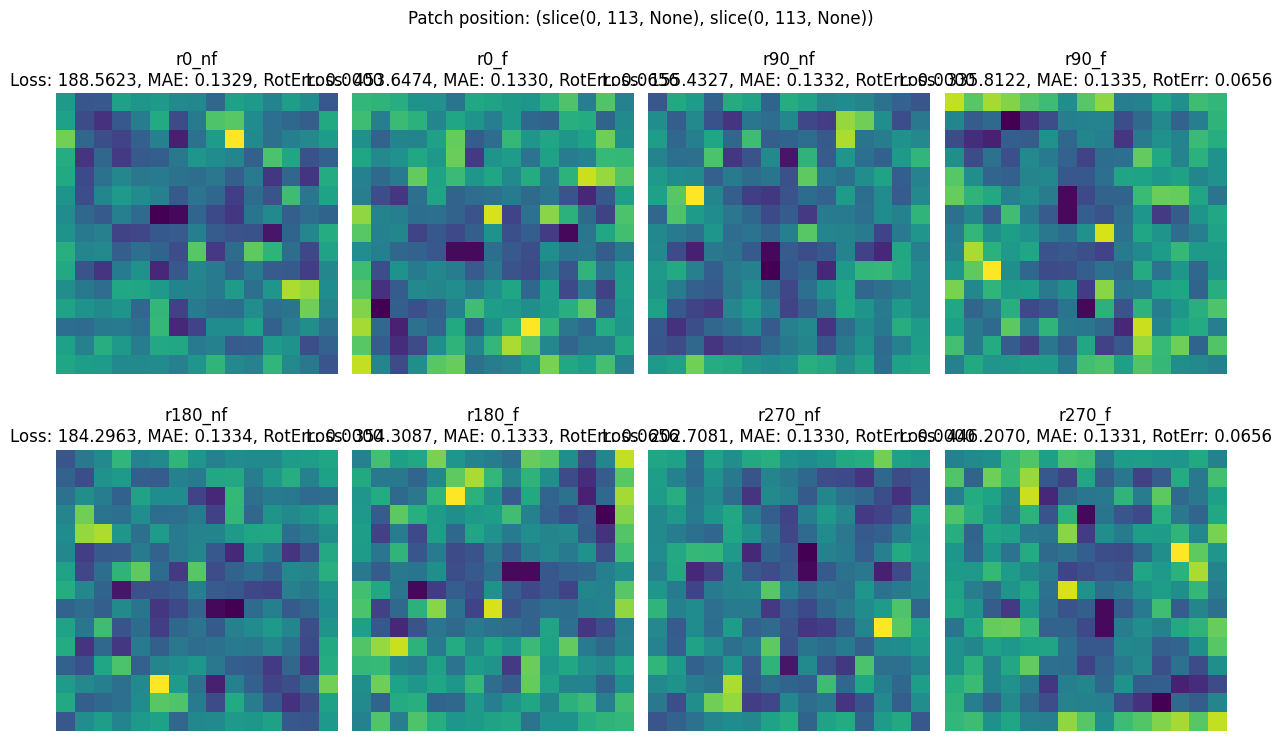

In [126]:
# plot example embeddings - test

import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        
        embedding = torch.rot90(torch.tensor(embedding), k=(1), dims=[-2, -1]).numpy()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:.4f}, RotErr: {value['rotation_error']:.4f}")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

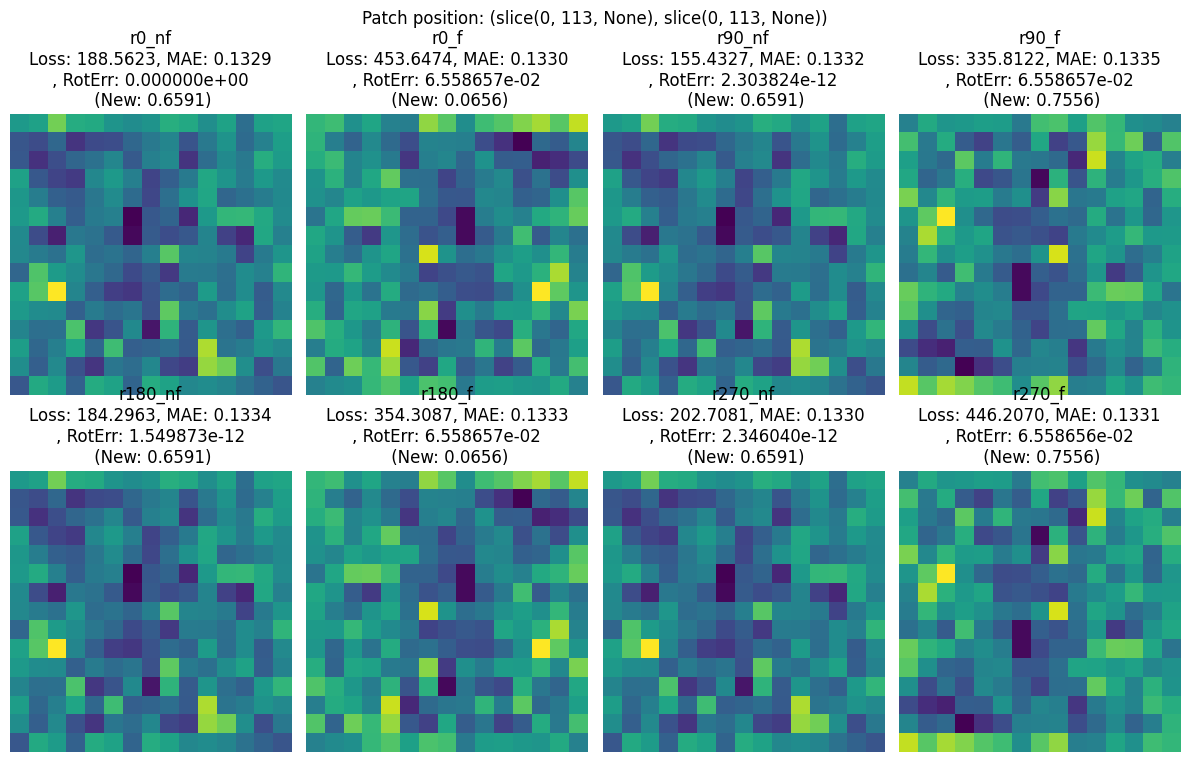

In [123]:
# plot example embeddings - test
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        flip = 1 if 'f' in key else 0
        rotation = int(key[1:key.index('_')])
        if flip > 0:
            embedding = torch.flip(torch.tensor(embedding), dims=[-1])
        if rotation > 0:
            embedding = torch.rot90(embedding, k=(rotation // 90), dims=[-2, -1])
        embedding = embedding.numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:.4f}\n, RotErr: {value['rotation_error']:e}\n (New: {new_rotation_error:.4f})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

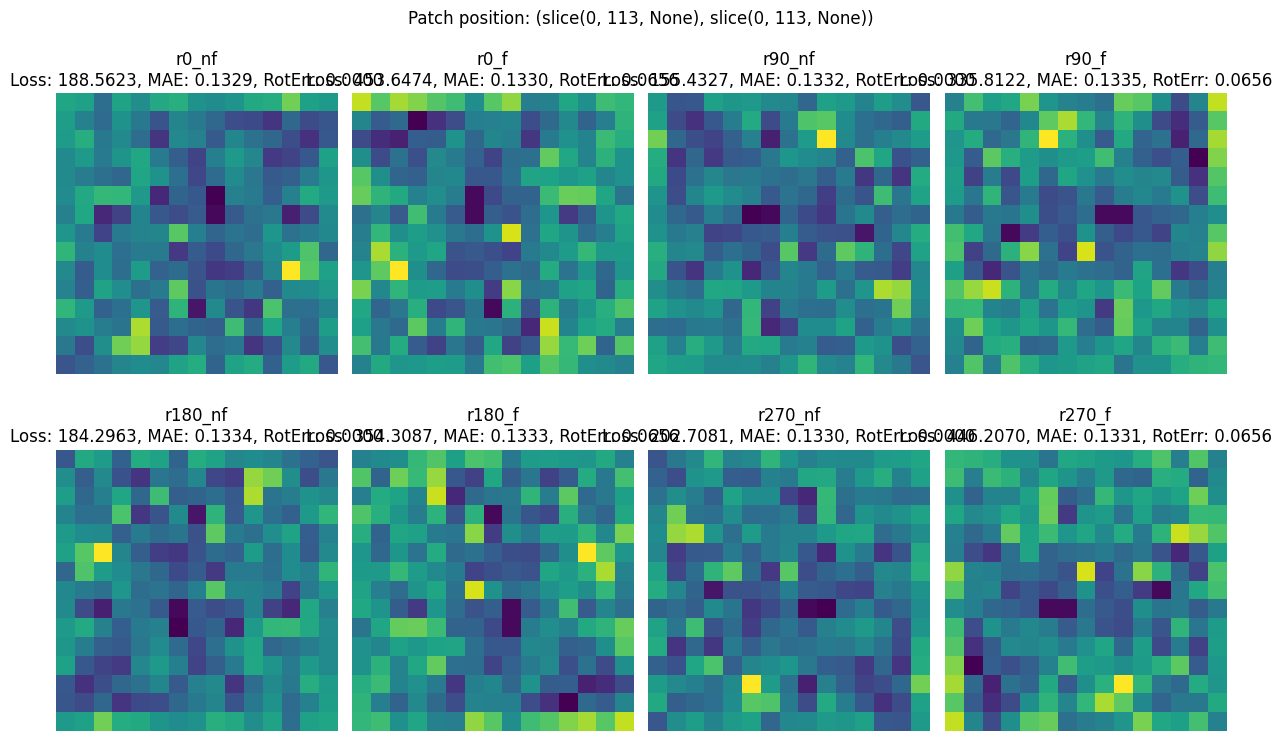

In [ ]:
# plot example embeddings - 2nd quarter

import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:.4f}, RotErr: {value['rotation_error']:.4f}")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

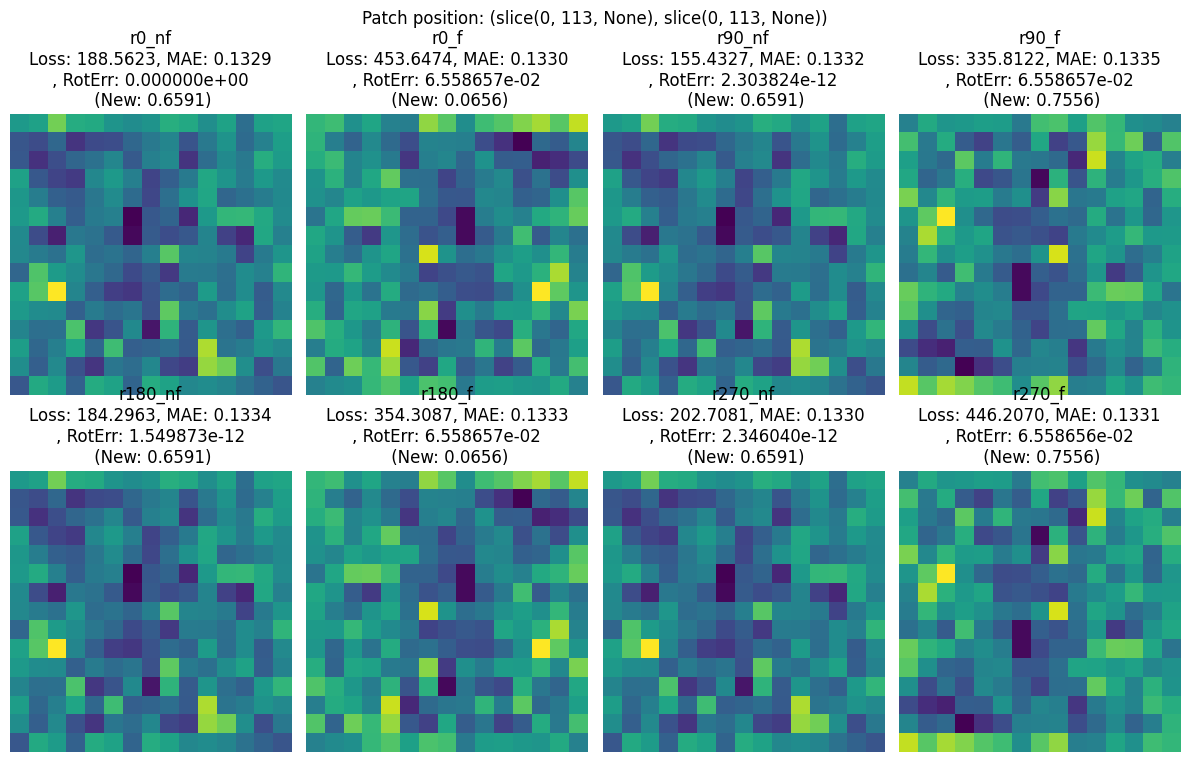

In [114]:
# plot example embeddings - 2nd quarter

import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        flip = 1 if 'f' in key else 0
        rotation = int(key[1:key.index('_')])
        if flip > 0:
            embedding = torch.flip(torch.tensor(embedding), dims=[-1])
        if rotation > 0:
            embedding = torch.rot90(embedding, k=(rotation // 90), dims=[-2, -1])
        embedding = embedding.numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:.4f}\n, RotErr: {value['rotation_error']:e}\n (New: {new_rotation_error:.4f})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

In [ ]:
import numpy as np
mean_mae = np.mean([
    patch["r270_nf"]["mae"] for img_path, patches in result_images.items() for patch in patches
])
mean_mae

0.17297998174514848

In [ ]:
import numpy as np
mean_mae = np.mean([
    patch["r270_nf"]["mae"] for img_path, patches in results_images.items() for patch in patches
])
mean_mae

0.1454678074533237

In [25]:

import pickle
with open(os.path.join("/raid/immucan/szlukasik_embeddings/EquivariantConvnext_20251004_191704_J2206-epoch_179/", "nsclc2_panel1_test.pkl"), "rb") as f:
    result_images = pickle.load(f)

In [ ]:

import pickle
with open(os.path.join("/raid/immucan/szlukasik_embeddings/EquivariantConvnext_20251004_191704_J2206-epoch_179/", "nsclc2_panel1_train_1st_quarter.pkl"), "rb") as f:
    result_images = pickle.load(f)

In [12]:

import pickle
with open(os.path.join("/raid/immucan/szlukasik_embeddings/EquivariantConvnext_20251004_191704_J2206-epoch_179/", "nsclc2_panel1_train_2nd_half.pkl"), "rb") as f:
    results_images = pickle.load(f)

In [24]:

import pickle
with open(os.path.join("/raid/immucan/szlukasik_embeddings/EquivariantConvnext_20251004_191704_J2206-epoch_179/", "nsclc2_panel1_train_2nd_half.pkl"), "wb") as f:
    pickle.dump(results_images, f)

In [34]:

import pickle
with open(os.path.join("/raid/immucan/szlukasik_embeddings/EquivariantConvnext_20251004_191704_J2206-epoch_179/", "nsclc2_panel1_test.pkl"), "wb") as f:
    pickle.dump(results_images, f)

In [27]:
results_images = result_images

In [28]:
len(results_images)

140

In [ ]:
import numpy as np
mean_mae = np.mean([
    patch["r270_f"]["mae"] for img_path, patches in result_test.items() for patch in patches
])
mean_mae

0.1718621984898438

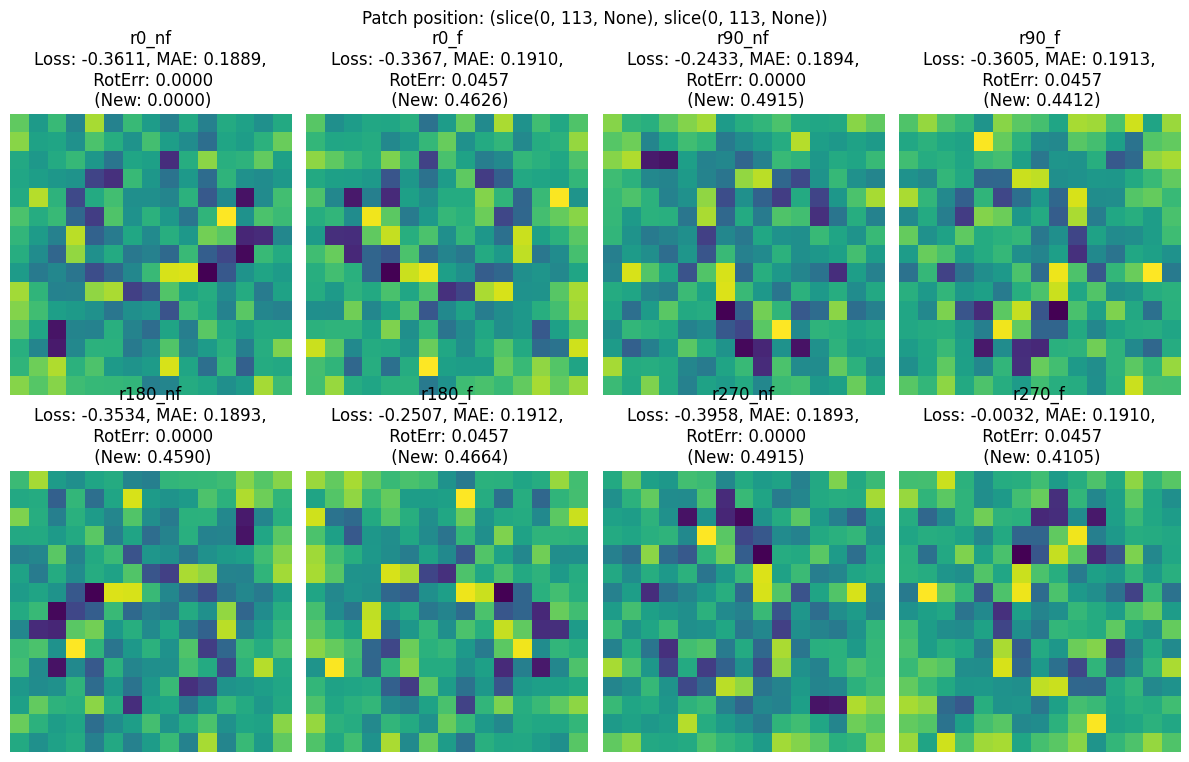

In [13]:
# plot example embeddings - test
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        # if rotation > 0:
        #     embedding = torch.rot90(torch.tensor(embedding), k=(- rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:.4f},\n RotErr: {value['rotation_error']:.4f}\n (New: {new_rotation_error:.4f})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

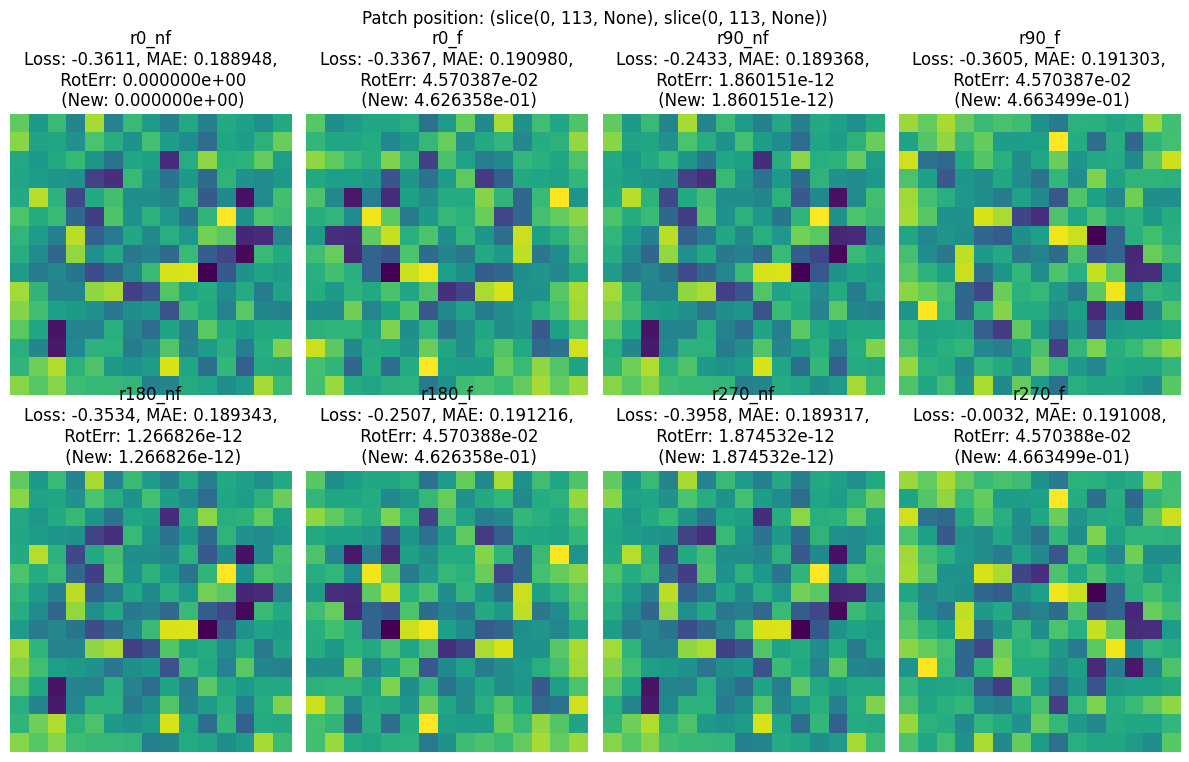

In [ ]:
# plot example embeddings - test
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        rotation = int(key[1:key.index('_')])
        if rotation > 0:
            embedding = torch.rot90(torch.tensor(embedding), k=(rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:2f},\n RotErr: {value['rotation_error']:e}\n (New: {new_rotation_error:e})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

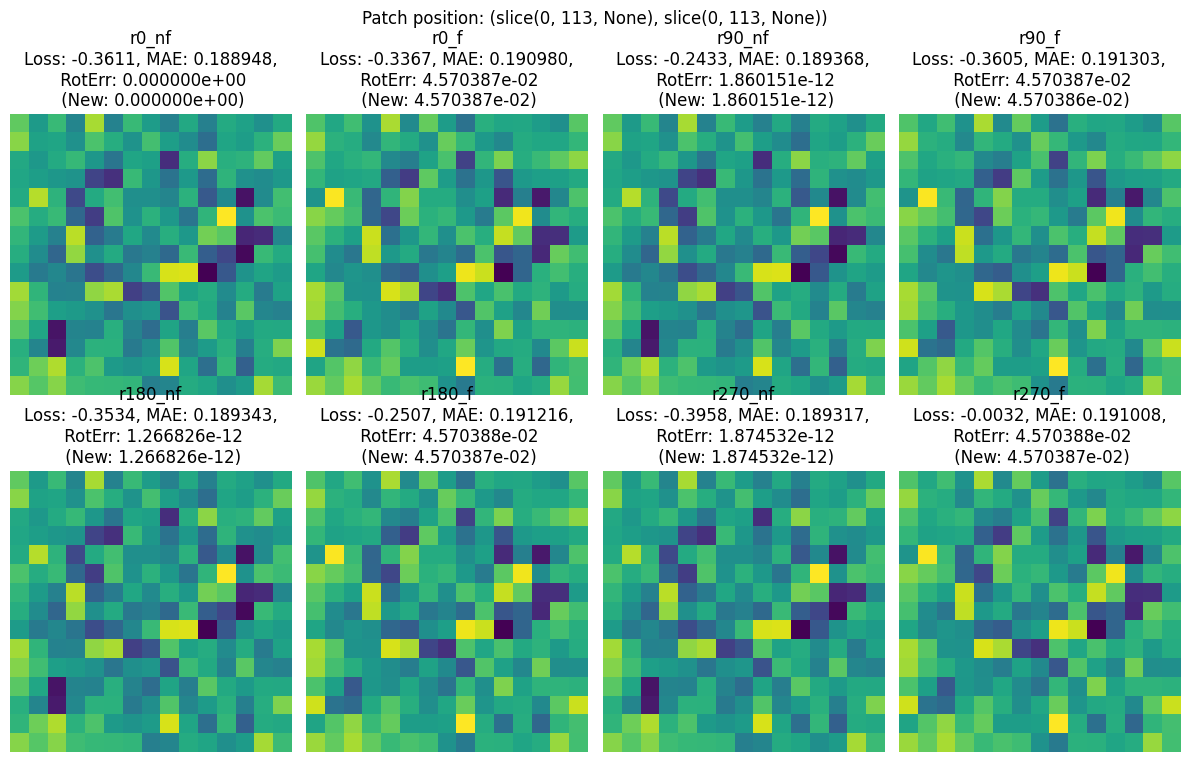

In [20]:
# plot example embeddings - test
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        rotation = int(key[1:key.index('_')])
        flip = 0 if 'nf' in key else 1
        if flip > 0:
            embedding = torch.flip(torch.tensor(embedding), dims=[-1]).numpy()
        if rotation > 0:
            embedding = torch.rot90(torch.tensor(embedding), k=(rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:2f},\n RotErr: {value['rotation_error']:e}\n (New: {new_rotation_error:e})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

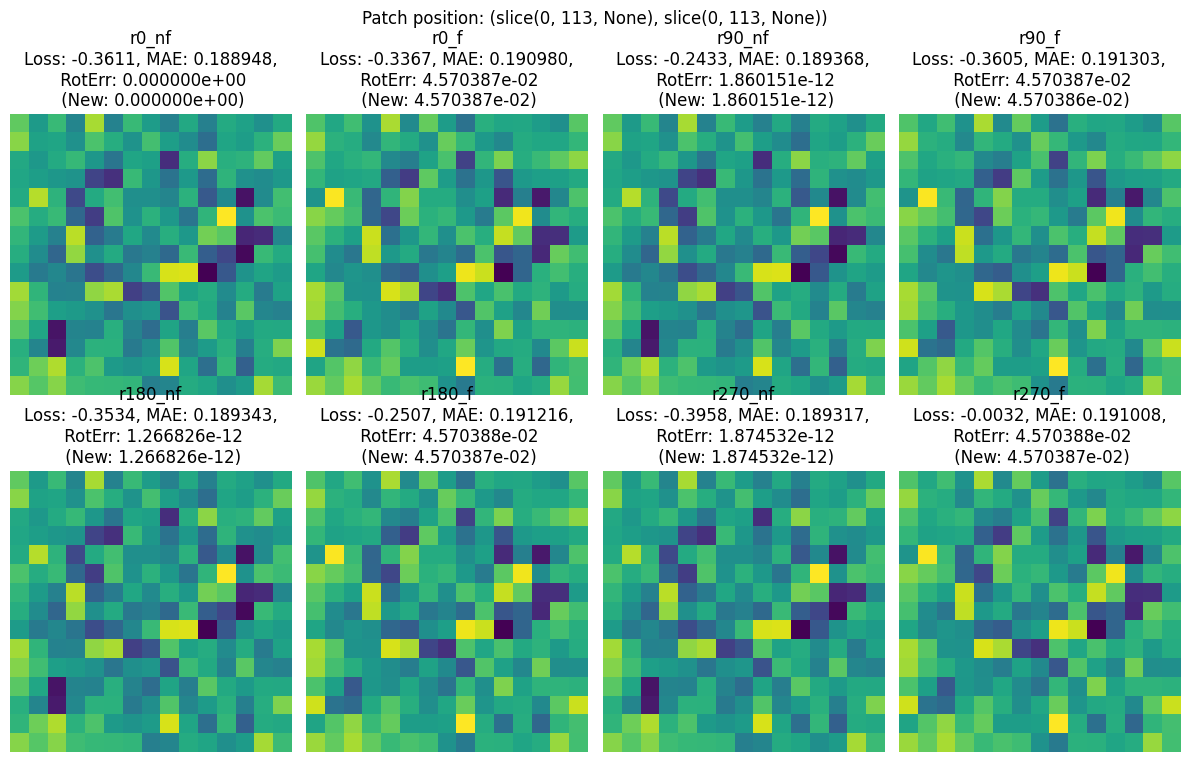

In [33]:
# plot example embeddings - test
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        rotation = int(key[1:key.index('_')])
        flip = 0 if 'nf' in key else 1
        if flip > 0:
            embedding = torch.flip(torch.tensor(embedding), dims=[-1]).numpy()
        if rotation > 0:
            embedding = torch.rot90(torch.tensor(embedding), k=(-rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:2f},\n RotErr: {value['rotation_error']:e}\n (New: {new_rotation_error:e})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

In [ ]:
# test
rotation_errors = {
    "r0_nf": [],
    "r0_f": [],
    "r90_nf": [],
    "r90_f": [],
    "r180_nf": [],
    "r180_f": [],
    "r270_nf": [],
    "r270_f": [],
}

for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (0, 90, 180, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                if flip > 0:
                    embedding = torch.flip(embedding, dims=[-1])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(rotation // 90), dims=[-2, -1])
                rotation_error = ((embedding -  torch.tensor(patch["r0_nf"]["embedding"])) ** 2).mean() / (torch.tensor(patch["r0_nf"]["embedding"]) ** 2).mean()
                if np.isclose(patch[key]["rotation_error"], rotation_error.item(), atol=1e-5) == False:
                    print(f"Mismatch in rotation error for {img_path} patch {patch['position']} key {key}: computed {rotation_error.item()}, stored {patch[key]['rotation_error']}")
                    raise Exception("Stop")
                # else:
                    # print("No mismatch for ", img_path, patch['position'], key, rotation_error.item(), patch[key]['rotation_error'])

 11%|█████████████████████▋                                                                                                                                                                                    | 15/140 [00:03<00:30,  4.11it/s]


KeyboardInterrupt: 

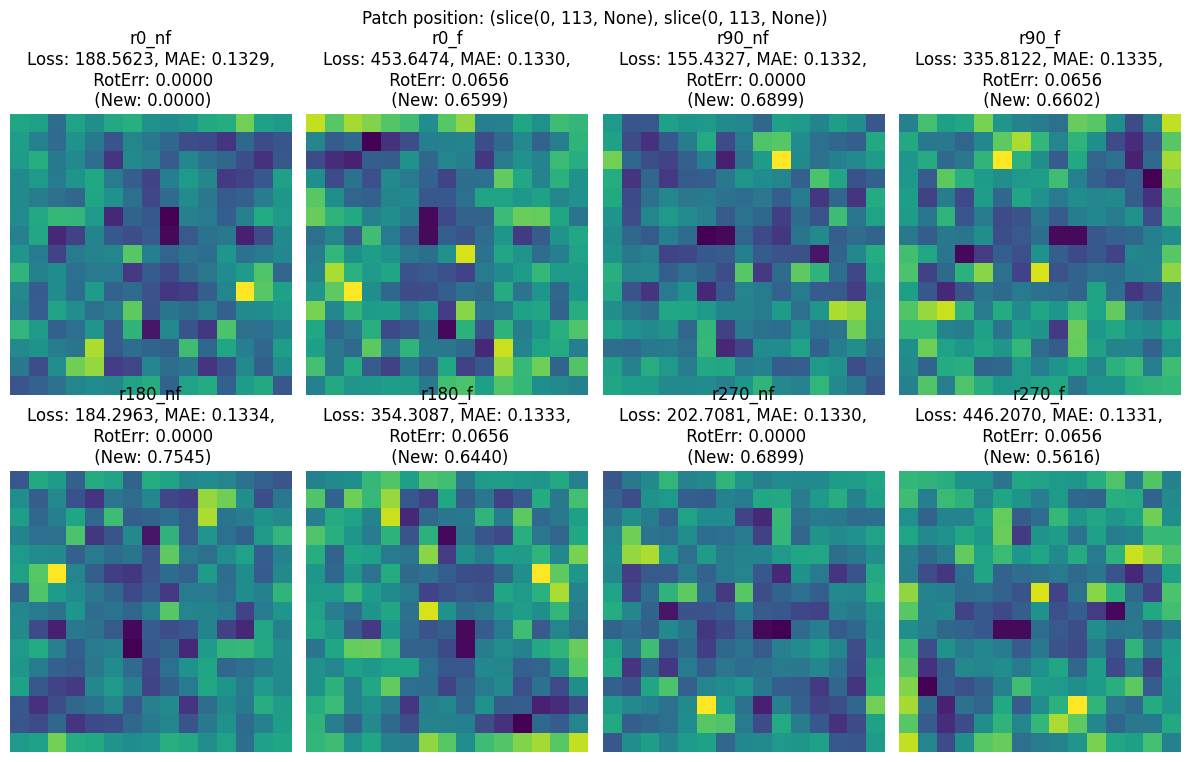

In [3]:
# plot example embeddings - 1st quarter
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        # if rotation > 0:
        #     embedding = torch.rot90(torch.tensor(embedding), k=(- rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:.4f},\n RotErr: {value['rotation_error']:.4f}\n (New: {new_rotation_error:.4f})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

/tmp/ipykernel_716039/1656004261.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.rot90(torch.tensor(embedding), k=(-rotation // 90), dims=[-2, -1]).numpy()


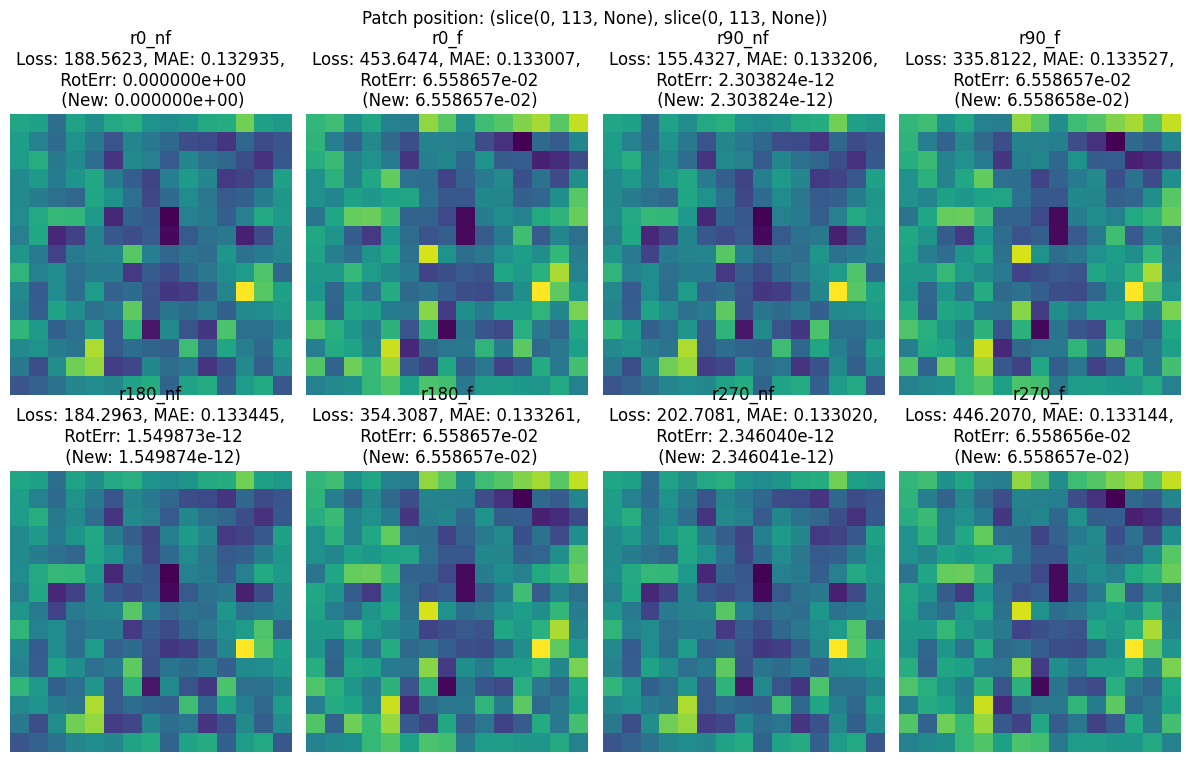

In [8]:
# plot example embeddings - 1st quarter
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        rotation = int(key[1:key.index('_')])
        flip = 0 if 'nf' in key else 1
        if flip > 0:
            embedding = torch.flip(torch.tensor(embedding), dims=[-1])
        if rotation > 0:
            # different than test
            embedding = torch.rot90(torch.tensor(embedding), k=(-rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:2f},\n RotErr: {value['rotation_error']:e}\n (New: {new_rotation_error:e})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

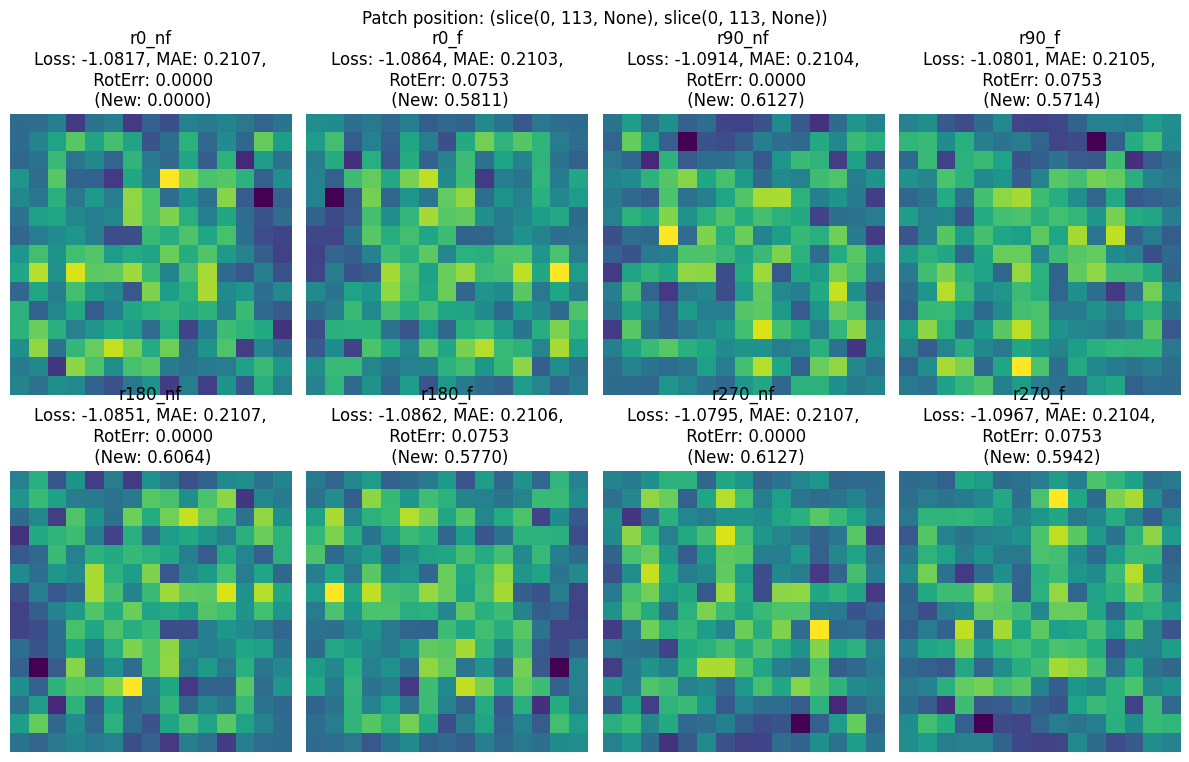

In [10]:
# plot example embeddings - 2nd quarter
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        # if rotation > 0:
        #     embedding = torch.rot90(torch.tensor(embedding), k=(- rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:.4f},\n RotErr: {value['rotation_error']:.4f}\n (New: {new_rotation_error:.4f})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

/tmp/ipykernel_716039/1629313281.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.rot90(torch.tensor(embedding), k=(-rotation // 90), dims=[-2, -1]).numpy()


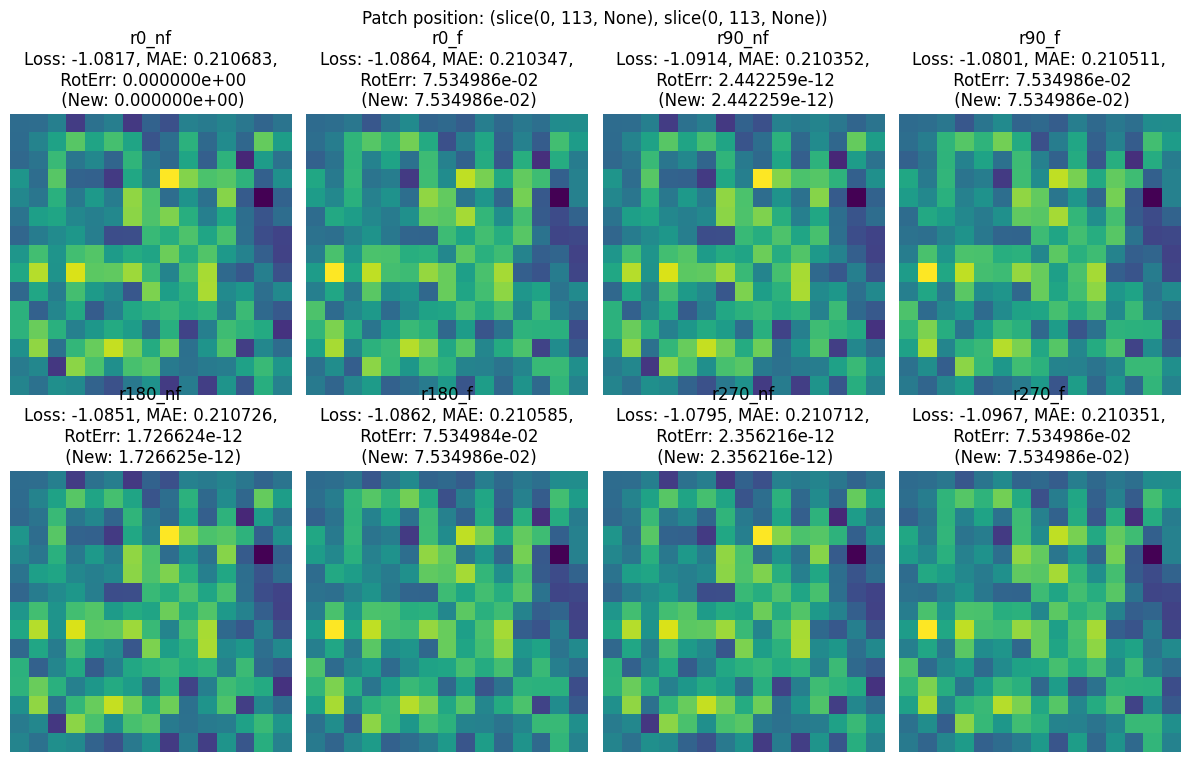

In [11]:
# plot example embeddings - 2nd quarter
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        rotation = int(key[1:key.index('_')])
        flip = 0 if 'nf' in key else 1
        if flip > 0:
            embedding = torch.flip(torch.tensor(embedding), dims=[-1])
        if rotation > 0:
            # different than test
            embedding = torch.rot90(torch.tensor(embedding), k=(-rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:2f},\n RotErr: {value['rotation_error']:e}\n (New: {new_rotation_error:e})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

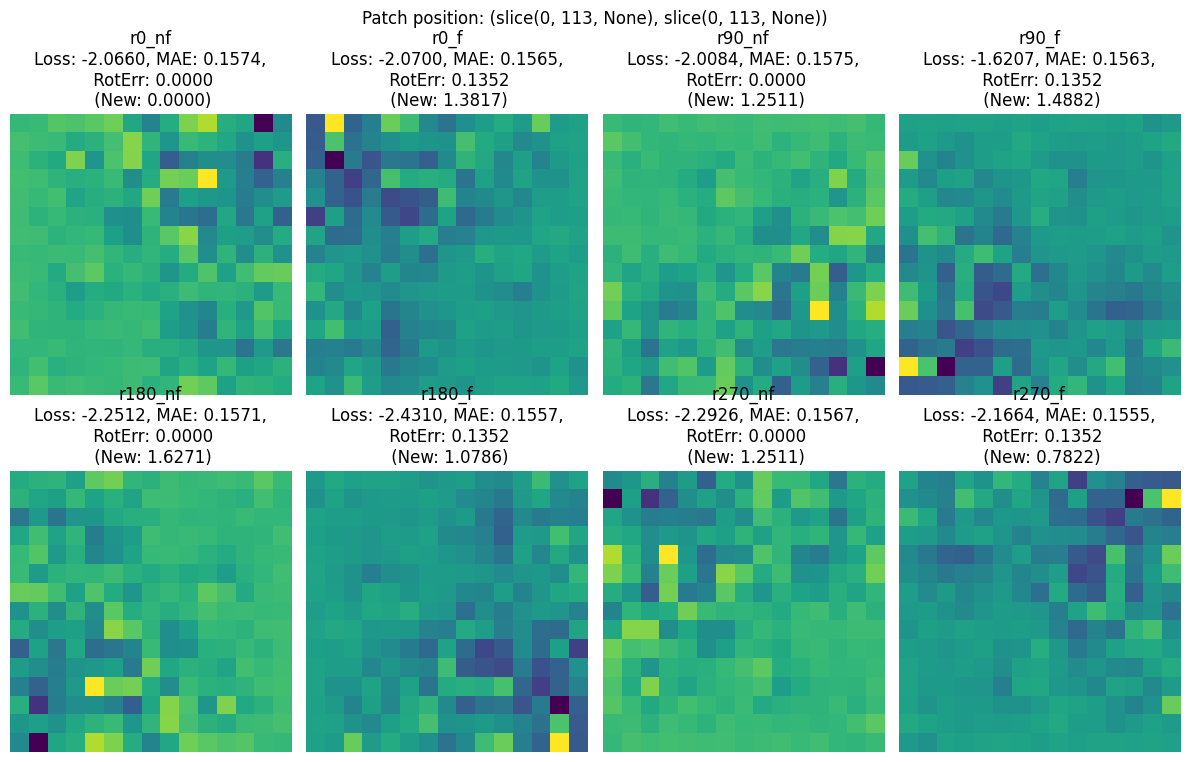

In [13]:
# plot example embeddings - 2nd hald
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        # if rotation > 0:
        #     embedding = torch.rot90(torch.tensor(embedding), k=(- rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:.4f},\n RotErr: {value['rotation_error']:.4f}\n (New: {new_rotation_error:.4f})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

/tmp/ipykernel_716039/731644322.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.rot90(torch.tensor(embedding), k=(rotation // 90), dims=[-2, -1]).numpy()


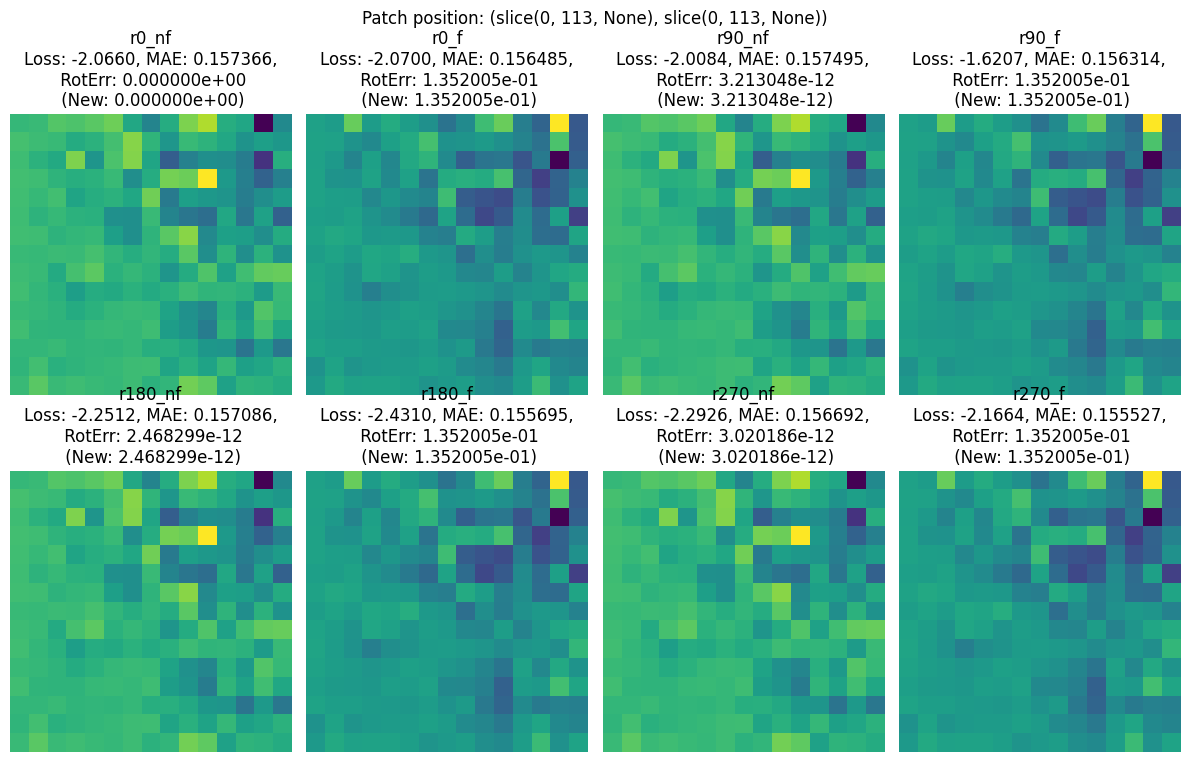

In [ ]:
# plot example embeddings - 2nd hald
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        rotation = int(key[1:key.index('_')])
        flip = 0 if 'nf' in key else 1
        if flip > 0:
            embedding = torch.flip(torch.tensor(embedding), dims=[-1])
        if rotation > 0:
            # same as test
            embedding = torch.rot90(torch.tensor(embedding), k=(rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:2f},\n RotErr: {value['rotation_error']:e}\n (New: {new_rotation_error:e})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

In [29]:

rotation_errors = {
    "r0_nf": [],
    "r0_f": [],
    "r90_nf": [],
    "r90_f": [],
    "r180_nf": [],
    "r180_f": [],
    "r270_nf": [],
    "r270_f": [],
}

for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (0, 90, 180, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                if flip > 0:
                    embedding = torch.flip(torch.tensor(embedding), dims=[-1])
                if rotation > 0:
                    # same as test
                    embedding = torch.rot90(torch.tensor(embedding), k=(rotation // 90), dims=[-2, -1])
                rotation_error = ((embedding -  torch.tensor(patch["r0_nf"]["embedding"])) ** 2).mean() / (torch.tensor(patch["r0_nf"]["embedding"]) ** 2).mean()
                if np.isclose(patch[key]["rotation_error"], rotation_error.item(), atol=1e-5) == False:
                    print(f"Mismatch in rotation error for {img_path} patch {patch['position']} key {key}: computed {rotation_error.item()}, stored {patch[key]['rotation_error']}")
                    raise Exception("Stop")
                # else:
                    # print("No mismatch for ", img_path, patch['position'], key, rotation_error.item(), patch[key]['rotation_error'])

  0%|                                                                                                                                                                                                                   | 0/140 [00:00<?, ?it/s]/tmp/ipykernel_716039/46488501.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.flip(torch.tensor(embedding), dims=[-1])
/tmp/ipykernel_716039/46488501.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.rot90(torch.tensor(embedding), k=(rotation // 90), dims=[-2, -1])
 24%|███████████████████████████████████████████████▌                                                                                            

KeyboardInterrupt: 

In [30]:

rotation_errors = {
    "r0_nf": [],
    "r0_f": [],
    "r90_nf": [],
    "r90_f": [],
    "r180_nf": [],
    "r180_f": [],
    "r270_nf": [],
    "r270_f": [],
}

for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (0, 90, 180, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                if flip > 0:
                    embedding = torch.flip(torch.tensor(embedding), dims=[-1])
                if rotation > 0:
                    # same as test
                    embedding = torch.rot90(torch.tensor(embedding), k=(rotation // 90), dims=[-2, -1])
                patch[key]["embedding"] = embedding.numpy()
                # rotation_error = ((embedding -  torch.tensor(patch["r0_nf"]["embedding"])) ** 2).mean() / (torch.tensor(patch["r0_nf"]["embedding"]) ** 2).mean()
                # if np.isclose(patch[key]["rotation_error"], rotation_error.item(), atol=1e-5) == False:
                #     print(f"Mismatch in rotation error for {img_path} patch {patch['position']} key {key}: computed {rotation_error.item()}, stored {patch[key]['rotation_error']}")
                #     raise Exception("Stop")
                # else:
                    # print("No mismatch for ", img_path, patch['position'], key, rotation_error.item(), patch[key]['rotation_error'])

  0%|                                                                                                                                                                                                                   | 0/140 [00:00<?, ?it/s]/tmp/ipykernel_716039/1885632834.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.flip(torch.tensor(embedding), dims=[-1])
/tmp/ipykernel_716039/1885632834.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.rot90(torch.tensor(embedding), k=(rotation // 90), dims=[-2, -1])
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [31]:

rotation_errors = {
    "r0_nf": [],
    "r0_f": [],
    "r90_nf": [],
    "r90_f": [],
    "r180_nf": [],
    "r180_f": [],
    "r270_nf": [],
    "r270_f": [],
}

for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (0, 90, 180, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                if rotation > 0:
                    # same as test
                    embedding = torch.rot90(torch.tensor(embedding), k=(rotation // 90), dims=[-2, -1])
                if flip > 0:
                    embedding = torch.flip(torch.tensor(embedding), dims=[-1])
                patch[key]["embedding"] = embedding.numpy()
                # rotation_error = ((embedding -  torch.tensor(patch["r0_nf"]["embedding"])) ** 2).mean() / (torch.tensor(patch["r0_nf"]["embedding"]) ** 2).mean()
                # if np.isclose(patch[key]["rotation_error"], rotation_error.item(), atol=1e-5) == False:
                #     print(f"Mismatch in rotation error for {img_path} patch {patch['position']} key {key}: computed {rotation_error.item()}, stored {patch[key]['rotation_error']}")
                #     raise Exception("Stop")
                # else:
                    # print("No mismatch for ", img_path, patch['position'], key, rotation_error.item(), patch[key]['rotation_error'])

  0%|                                                                                                                                                                                                                   | 0/140 [00:00<?, ?it/s]/tmp/ipykernel_716039/768427412.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.flip(torch.tensor(embedding), dims=[-1])
/tmp/ipykernel_716039/768427412.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.rot90(torch.tensor(embedding), k=(rotation // 90), dims=[-2, -1])
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

/tmp/ipykernel_716039/4263221785.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.rot90(torch.tensor(embedding), k=(-rotation // 90), dims=[-2, -1]).numpy()


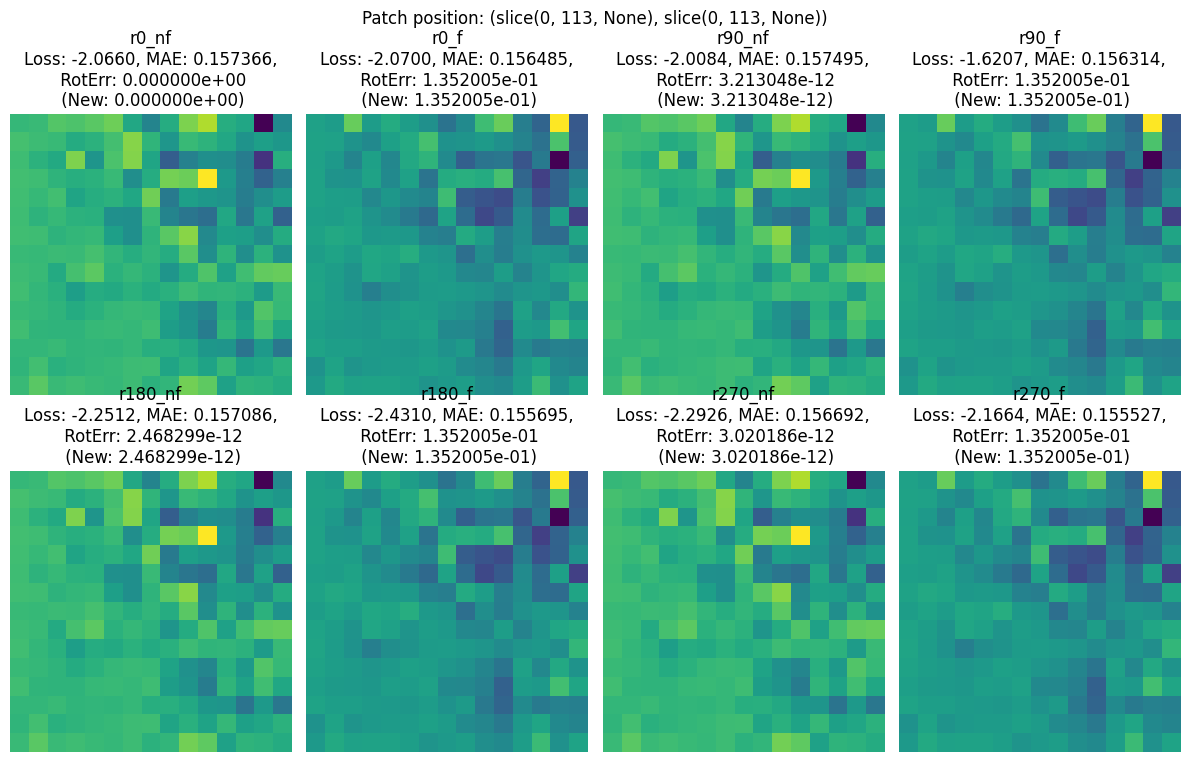

In [20]:
# plot example embeddings - 2nd half - after processing
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        rotation = int(key[1:key.index('_')])
        flip = 0 if 'nf' in key else 1
        if flip > 0:
            embedding = torch.flip(torch.tensor(embedding), dims=[-1])
        if rotation > 0:
            # now different than test
            embedding = torch.rot90(torch.tensor(embedding), k=(-rotation // 90), dims=[-2, -1]).numpy()
        embedding_org = patch["r0_nf"]["embedding"]
        new_rotation_error = ((embedding -  embedding_org) ** 2).mean() / (embedding_org ** 2).mean()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:2f},\n RotErr: {value['rotation_error']:e}\n (New: {new_rotation_error:e})")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

In [32]:

rotation_errors = {
    "r0_nf": [],
    "r0_f": [],
    "r90_nf": [],
    "r90_f": [],
    "r180_nf": [],
    "r180_f": [],
    "r270_nf": [],
    "r270_f": [],
}

for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        for rotation in (0, 90, 180, 270):
            for flip in (0, 1):
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                embedding = torch.tensor(patch[key]["embedding"])
                if flip > 0:
                    embedding = torch.flip(torch.tensor(embedding), dims=[-1])
                if rotation > 0:
                    # same as test
                    embedding = torch.rot90(torch.tensor(embedding), k=(-rotation // 90), dims=[-2, -1])
                rotation_error = ((embedding -  torch.tensor(patch["r0_nf"]["embedding"])) ** 2).mean() / (torch.tensor(patch["r0_nf"]["embedding"]) ** 2).mean()
                if np.isclose(patch[key]["rotation_error"], rotation_error.item(), atol=1e-5) == False:
                    print(f"Mismatch in rotation error for {img_path} patch {patch['position']} key {key}: computed {rotation_error.item()}, stored {patch[key]['rotation_error']}")
                    raise Exception("Stop")
                # else:
                    # print("No mismatch for ", img_path, patch['position'], key, rotation_error.item(), patch[key]['rotation_error'])

  0%|                                                                                                                                                                                                                   | 0/140 [00:00<?, ?it/s]/tmp/ipykernel_716039/2197875545.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.flip(torch.tensor(embedding), dims=[-1])
/tmp/ipykernel_716039/2197875545.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.rot90(torch.tensor(embedding), k=(-rotation // 90), dims=[-2, -1])
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [ ]:
model = model.eval()

In [ ]:
all_results = []
for  img, channel_ids, panel_idx, img_path in tqdm(test_dataloader):
    results = {}
    for rotation in [0, 90, 180, 270]:
        img = img.to(device).to(torch.float32)
        for flip in [False, True]:
            if rotation > 0:
                img = torch.rot90(img, k=rotation // 90, dims=[2, 3])
            if flip:
                img = torch.flip(img, dims=[3])
            key = f"r{rotation}" + ("_f" if flip else "_nf")
            img = img.to(device)
            # img = img[:, :, 1:-2, 1:-2]
            num_channels = img.shape[1]
            channel_ids = torch.tensor([panel_1_indices]).to(device)
            with torch.no_grad():
                output = model(img, channel_ids, channel_ids, True)
            features = output["features"]
            reconstructions = output["output"]
            reconstructions = reconstructions[:, :, 3:-4, 3:-4]
            mi, logsigma = reconstructions.unbind(dim=-1)
            mi = torch.sigmoid(mi)
            mae = torch.abs(mi - img).mean().item()
            results[key] = {}
            results[key]["latent"]= features[-1].cpu().detach().numpy()[0]
            # print(results[key]["latent"].shape)
            # results[key]["img"] = img.cpu().detach().numpy()
            # results[key]["reconstruction"] = mi.cpu().detach().numpy()
    all_results.append(results)
    break  # Process only the first batch for demonstration



  0%|                                                                                        | 0/149 [00:00<?, ?it/s]

0


  0%|                                                                                        | 0/149 [00:01<?, ?it/s]


In [ ]:
def plot_all_results(all_results):
    for results in all_results:
        plt.figure(figsize=(12, 8))
        for i, (key, value) in enumerate(results.items()):
            embedding = value["latent"]
            plt.subplot(2, 4, i + 1)
            plt.imshow(embedding[0], cmap='viridis')
            plt.title(f"{key}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    return
plot_all_results(all_results)

NameError: name 'all_results' is not defined

In [ ]:
len(results_images)

0

In [ ]:
results_images[list(results_images.keys())[0]][0].keys()

dict_keys(['r0_nf', 'r0_f', 'r90_nf', 'r90_f', 'r180_nf', 'r180_f', 'r270_nf', 'r270_f', 'position'])

In [ ]:
results_images[list(results_images.keys())[0]][0]["r0_nf"].keys()

dict_keys(['embedding', 'loss', 'mae', 'rotation_error'])

In [ ]:
mean_mae = np.mean([
    patch["r0_nf"]["mae"] for img_path, patches in results_images.items() for patch in patches
])
mean_mae

0.1729923784415116

In [ ]:
mean_mae = np.mean([
    patch["r270_f"]["rotation_error"] for img_path, patches in results_images.items() for patch in patches
])
mean_mae

0.06462443931689522

In [ ]:
results_images[list(results_images.keys())[0]][0]["r0_nf"]["embedding"].shape

(1, 512, 14, 14)

In [ ]:
results_images[list(results_images.keys())[0]][0]["r270_nf"]["rotation_error"]

0.8717069029808044

In [ ]:
results_images[list(results_images.keys())[0]][0]["r270_nf"]["rotation_error"] # 0.33

2.1357382008757586e-12

In [ ]:
results_images[list(results_images.keys())[0]][0]["r270_f"]["rotation_error"] # 0.33

0.13520050048828125

In [ ]:
results_images[list(results_images.keys())[0]][0]["r0_f"]["rotation_error"] # 0.33

0.13520048558712006

In [ ]:
all_results[0].keys()

dict_keys(['r0_nf', 'r0_f', 'r90_nf', 'r90_f', 'r180_nf', 'r180_f', 'r270_nf', 'r270_f'])

In [ ]:
len(results_images[list(results_images.keys())[0]])

36

In [ ]:
ckpt_name = os.path.basename(ckpt_path).replace("checkpoint-", "").replace(".pth", "")
ckpt_name

'EquivariantConvnext_20251004_191704_J2206-epoch_179'

In [ ]:
embeddings_dir = f"embeddings/{ckpt_name}"
os.makedirs(embeddings_dir, exist_ok=True)

import pickle
with open(os.path.join(embeddings_dir, "nsclc2_panel1_test.pkl"), "wb") as f:
    pickle.dump(results_images, f)

In [76]:
embeddings_dir = f"embeddings/{ckpt_name}"
os.makedirs(embeddings_dir, exist_ok=True)

import pickle
with open(os.path.join(embeddings_dir, "nsclc2_panel1_train_1st_quarter.pkl"), "wb") as f:
    pickle.dump(results_images, f)

In [ ]:
len(results_images)

140

In [ ]:
# we want to transform results_images into a dataframe with columns: 'img_path', 'panel', 'coords0', 'coords1', 'split', 'embedding_0', 'embedding_90'
rows = []
for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        (h_slice, w_slice) = patch["position"]
        coords0 = (h_slice.start, w_slice.start)
        coords1 = (h_slice.stop, w_slice.stop)
        row = {
            "img_path": img_path[0],
            "panel": 1,
            "coords0": coords0,
            "coords1": coords1,
            "split": "test",
            "embedding_0": patch[0]["embedding"],
            "embedding_90": patch[90]["embedding"],
        }
        rows.append(row)

# df_results = pd.DataFrame(rows)
# df_results

  0%|                                                                                                        | 0/140 [00:00<?, ?it/s]


KeyError: 0

In [ ]:
df_test = pd.DataFrame(rows)
df_results = pd.concat([df_results, df_test], ignore_index=True)

In [ ]:
df.columns

Index(['img_path', 'panel', 'coords0', 'coords1', 'embeddings', 'split'], dtype='object')

In [ ]:
df.head()

,img_path,panel,coords0,coords1,embeddings,split
0,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 0)","(112, 112)","[[38, 51, 34, 105, 34, 219, 34, 34, 32, 128, 2...",train
1,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 112)","(112, 224)","[[233, 89, 153, 153, 219, 219, 153, 125, 34, 3...",train
2,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 224)","(112, 336)","[[120, 156, 176, 148, 9, 203, 135, 126, 176, 2...",train
3,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 336)","(112, 448)","[[135, 124, 59, 129, 144, 124, 152, 203, 229, ...",train
4,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 448)","(112, 560)","[[134, 134, 134, 134, 134, 83, 134, 134, 134, ...",train


In [ ]:
len(df)

33370

In [ ]:
len(df_results) / 36

557.0

In [ ]:
len(df_results) / 36 - 557

140.0

In [ ]:
len(df_results) / 36

557.0

In [ ]:
len(results_images)

6

In [ ]:
df_results.head()

,img_path,panel,coords0,coords1,split,embedding_0,embedding_90,loss_0,loss_90,rotation_error
0,/raid/immucan/immuvis_splits/train/nsclc2-pane...,1,"(0, 0)","(112, 112)",train,[[[[-0.15919651 -0.15374859 -0.18189625 0.094...,[[[[-0.20314324 -0.16281724 -0.18512431 -0.050...,-9.229684,-9.230895,0.507075
1,/raid/immucan/immuvis_splits/train/nsclc2-pane...,1,"(0, 112)","(112, 224)",train,[[[[ 0.02772814 -0.08082461 -0.19362926 -0.095...,[[[[-0.09598845 -0.07064135 -0.07069875 -0.243...,-9.070560,-9.066478,0.513410
2,/raid/immucan/immuvis_splits/train/nsclc2-pane...,1,"(0, 224)","(112, 336)",train,[[[[-0.08583823 -0.16660969 -0.01590262 -0.075...,[[[[-0.05054139 -0.07759058 -0.02191173 0.049...,-9.304291,-9.304797,0.536570
3,/raid/immucan/immuvis_splits/train/nsclc2-pane...,1,"(0, 336)","(112, 448)",train,[[[[-0.13676113 0.09383862 -0.110382 -0.072...,[[[[-0.17256033 -0.07320142 -0.06913981 0.041...,-8.984298,-8.976571,0.501279
4,/raid/immucan/immuvis_splits/train/nsclc2-pane...,1,"(0, 448)","(112, 560)",train,[[[[-0.05780647 -0.09576567 -0.1400727 0.022...,[[[[ 0.01046866 0.0354061 -0.17619559 -0.104...,-9.111286,-9.110720,0.543222


In [ ]:
# save to pkl
import pickle
with open("inference_results_panel1.pkl", "wb") as f:
    pickle.dump(results_images, f)

In [ ]:
len(df_results) / 36

697.0

In [ ]:
# save train results dataframe as pkl
df_results.to_pickle("inference_results_panel1_df.pkl")

In [ ]:
# read train from pkl
df_results = pd.read_pickle("train_set_inference_results_panel1_df.pkl")

In [ ]:
# read from pkl
import pickle
with open("test_set_inference_results_panel1.pkl", "rb") as f:
    results_images = pickle.load(f)

In [ ]:
# save to pkl
import pickle
with open("test_set_inference_results_panel1.pkl", "wb") as f:
    pickle.dump(results_images, f)

In [ ]:
# calculate average rotation error
rotation_errors = []
for img_path, patches in results_images.items():
    for patch in patches:
        rotation_errors.append(patch[90]['rotation_error'])
np.mean(rotation_errors)

# for 


0.47991291735735203

In [ ]:
# 

In [ ]:
rotation_errors

[]

In [ ]:
torch.Size([1, 40, 88, 112]) torch.Size([1, 40, 88, 112]) torch.Size([1, 40, 90, 112])

In [ ]:
mi, logsigma = output.unbind(dim=-1)
mi = torch.sigmoid(mi)

loss = nll_loss(masked_img, mi, logsigma)
running_loss += loss.item()
running_mae += torch.abs(masked_img - mi).mean().item()